In [4]:
##############################################################
# ZADANIE: #2 Stworz model klasyfikacji dla zbioru danych: wines dane i opis dostepne pod
# adresem: http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/
##############################################################

# Analiza danych ze zbioru wine-quality
#
#
# Ponizej beda trzy sekcje z uzyciem klasyfikatorow:
#  C5.0
#  rpart
#  NaiveBayes
# 
#  Przeprowadzam eksperymenty uzywajac wszystkich atrybutow, potem ich ilosc zmniejszam tak
#  aby zapewnic maksymalna sprawnosc i minimalna zlozonosc.
#
#  Dla kazdego eksperymentu rysuje drzewo (jesli implementacja pozwala), krzywe ROC i Lift. 
#  Dodatkowo zbieram wszystkie wyniki i opisy w ramce results.
#
#  Kod mozna uruchomic w calosci, przejrzec diagramy oraz wykresy od konca, a takze porownac z ramka results.
#  Ramke mozna posortowac np. wedlug BalancedAccuracy i porownac jaka sprawnosc mialy modele. 
#
#  Stosunkowo najprostszy i najlepszy okazal sie klasyfikator C5.0 uzywajacy 2 atrybutow - 
#  ramka resutls try_num = 5 i AUC: 0.994 na zbiorze testowym. 
#
#  Wartosci AUC - nastepnym razem zbiore takze w ramce results - w tej wersji dostepne da na wykresie ROC.
#

# Zrodla: O rpart - wyswietlanie drzew, http://www.milbo.org/rpart-plot/prp.pdf

install.packages('gmodels') #bib. do analizy wynik???w
install.packages('Hmisc') #bib. do analizy wynik???w
install.packages('party') #bib. zawieraj???cca ctree()
install.packages('caret') #bib. do reprezentacji graficznej
install.packages('rpart') #bib. zawieraj???ca rpart()
install.packages('rpart.plot') 
install.packages('e1071') #bib. zawieraj???ca klasyfik. Bayesa
install.packages('C50') #bib. zawieraj???ca klasyfik. C5.0
install.packages('pROC')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘gtools’, ‘gdata’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘png’, ‘jpeg’, ‘checkmate’, ‘Formula’, ‘latticeExtra’, ‘gridExtra’, ‘data.table’, ‘htmlTable’, ‘viridis’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘TH.data’, ‘libcoin’, ‘matrixStats’, ‘multcomp’, ‘mvtnorm’, ‘modeltools’, ‘strucchange’, ‘coin’, ‘zoo’, ‘sandwich’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘iterators’, ‘gower’, ‘ipred’, ‘timeDate’, ‘foreach’, ‘plyr’, ‘ModelMetrics’, ‘reshape2’, ‘recipes’, ‘pROC’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(

In [5]:


library(gmodels) #bib. do analizy wynik???w
library(Hmisc) #bib. do analizy wynik???w
library(party) #bib. zawieraj???cca ctree()
library(caret) #bib. do reprezentacji graficznej
library(rpart) #bib. zawieraj???ca rpart()
library(rpart.plot) 
library(e1071) #bib. zawieraj???ca klasyfik. Bayesa
library(C50) #bib. zawieraj???ca klasyfik. C5.0
library(pROC)

install.packages('ROCR')
library(ROCR)

options(digits=3)


set.seed(71)


Loading required package: lattice

Loading required package: survival

Loading required package: Formula

Loading required package: ggplot2


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:base’:

    format.pval, units


Loading required package: grid

Loading required package: mvtnorm

Loading required package: modeltools

Loading required package: stats4

Loading required package: strucchange

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich


Attaching package: ‘caret’


The following object is masked from ‘package:survival’:

    cluster



Attaching package: ‘e1071’


The following object is masked from ‘package:Hmisc’:

    impute


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following object is masked from ‘package:gmodels’:

    ci


The following objects are masked from ‘package:stats’:

 

In [7]:

# ZALADUJ DANE:

download.file('http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', 'wine_red.csv');
download.file('http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', 'wine_white.csv');


In [8]:

##
## FUNKCJE POMOCNICZE
##

# Funkcja do podzialu na zbior treningowy i testowy
split_train_test <- function(wines, ratio=0.7)
{
  train_sample = wines
  dim(wines)
  ## z przykladu
  set.seed(123)
  nmbOfWines = dim(wines)[1]
  train_sample = sample(nmbOfWines, nmbOfWines*ratio)
  
  train = wines[train_sample,]
  test = wines[-train_sample,]
  return (list("train"= train, "test" = test))
}
# Pokazanie tablicy pomylek i statystyk modelu
model_stats <- function(mod, test)
{
  pred<-predict(mod, test, type='class')
  cm = confusionMatrix(test$class, pred)
  
  print (cm$table)
  print (cm$overall)
  print (cm$byClass) 
  
  return (cm)
}

# Narysowanie krzywych ROC I lift 
draw_roc_lift <- function (rpTree, test, text, pred_result_type='prob')
{
  predSexProb = predict(rpTree,test, type=pred_result_type)

    # Zebranie prawd. w dataframe
  df_p = data.frame(predSexProb)

  # Plot the performance of the model applied to the evaluation set as
  # an ROC curve.
  pred <- prediction(df_p$W, test$class)
  perf <- performance(pred,"tpr","fpr")
  #plot(perf, main="ROC curve", colorize=T)
  
  # Zwykly roc - czytelniejszy na poczatku :)
  roc(test$class, df_p$R, plot=TRUE, print.auc=TRUE)
  legend("bottomright", legend=text)
  
  # And then a lift chart
  perf <- performance(pred,"lift","rpp")
  auc <- performance(pred,"auc")
  
  title = sprintf("lift curve - %s", text)
  
  plot(perf, main=title, colorize=T)
}


# Zwraca nowy numer eksperymentu
trys = 0
next_try <- function()
{
  trys <<- trys+1
}
  
# Zebranie matrycy pomylek w dataframe
store_cm <- function (results, cm, desc)
{
  desc = append(desc, cm$byClass)
  desc = append(desc, cm$overall)
  results = rbind(results, desc) 
  
  return (results)
  
}


In [9]:

#
# Przypisz kategorie W-WHITE R - RED
#
wineRed_ds = read.table("wine_red.csv", header = TRUE, sep=";", na.strings= "*")
wineRed_ds$class = 'R'

wineWhite_ds = read.table("wine_white.csv", header = TRUE, sep=";", na.strings= "*")
wineWhite_ds$class = 'W'

wines_orginal = data.frame()

wines_orginal = rbind(wines_orginal,wineRed_ds)
wines_orginal = rbind(wines_orginal,wineWhite_ds)

wines_orginal$class = factor(wines_orginal$class)



Call:
C5.0.formula(formula = class ~ ., data = train, trials = 10, rules = TRUE)


C5.0 [Release 2.07 GPL Edition]  	Tue Oct 20 21:22:26 2020
-------------------------------

Class specified by attribute `outcome'

Read 4547 cases (13 attributes) from undefined.data

-----  Trial 0:  -----

Rules:

Rule 0/1: (825, lift 4.1)
	chlorides > 0.048
	total.sulfur.dioxide <= 70
	density > 0.99323
	sulphates > 0.46
	->  class R  [0.999]

Rule 0/2: (807, lift 4.1)
	volatile.acidity > 0.275
	residual.sugar <= 5.35
	chlorides > 0.048
	total.sulfur.dioxide <= 70
	->  class R  [0.999]

Rule 0/3: (367, lift 4.1)
	total.sulfur.dioxide <= 70
	density > 0.99379
	sulphates > 0.65
	->  class R  [0.997]

Rule 0/4: (250, lift 4.1)
	volatile.acidity > 0.22
	residual.sugar > 1.15
	total.sulfur.dioxide <= 70
	pH > 3.39
	->  class R  [0.996]

Rule 0/5: (259/1, lift 4.0)
	fixed.acidity > 9.1
	chlorides > 0.067
	->  class R  [0.992]

Rule 0/6: (19, lift 3.9)
	volatile.acidity > 0.47
	pH > 3.62
	->  class R  [0.9

          Reference
Prediction    R    W
         R  474   10
         W    2 1464
      Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
      9.94e-01       9.83e-01       9.89e-01       9.97e-01       7.56e-01 
AccuracyPValue  McnemarPValue 
     8.05e-213       4.33e-02 
         Sensitivity          Specificity       Pos Pred Value 
               0.996                0.993                0.979 
      Neg Pred Value            Precision               Recall 
               0.999                0.979                0.996 
                  F1           Prevalence       Detection Rate 
               0.988                0.244                0.243 
Detection Prevalence    Balanced Accuracy 
               0.248                0.995 


Setting levels: control = R, case = W

Setting direction: controls > cases



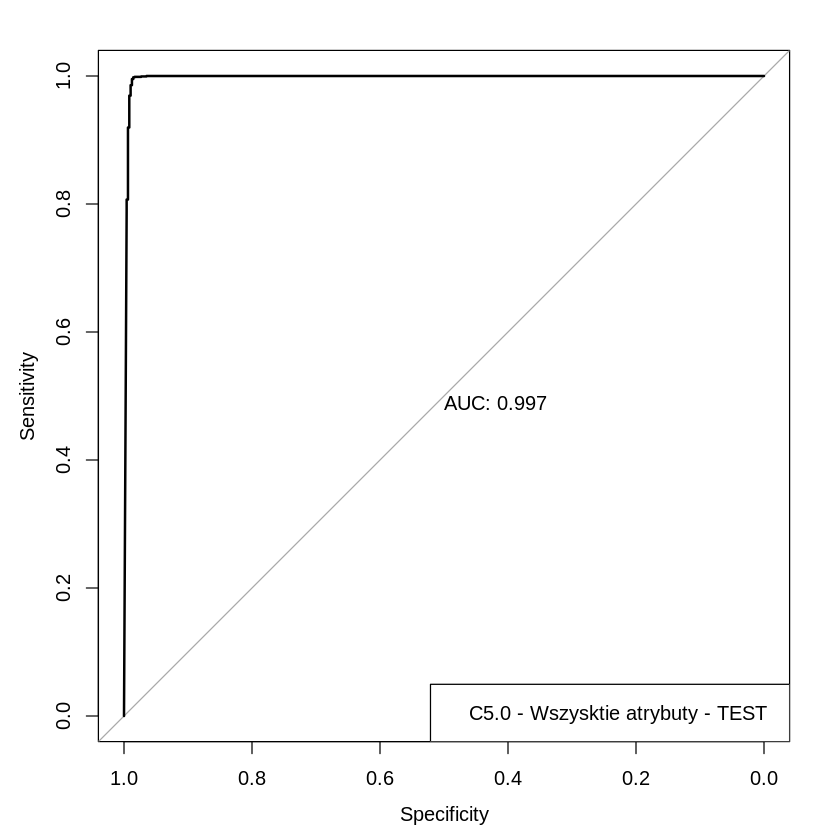

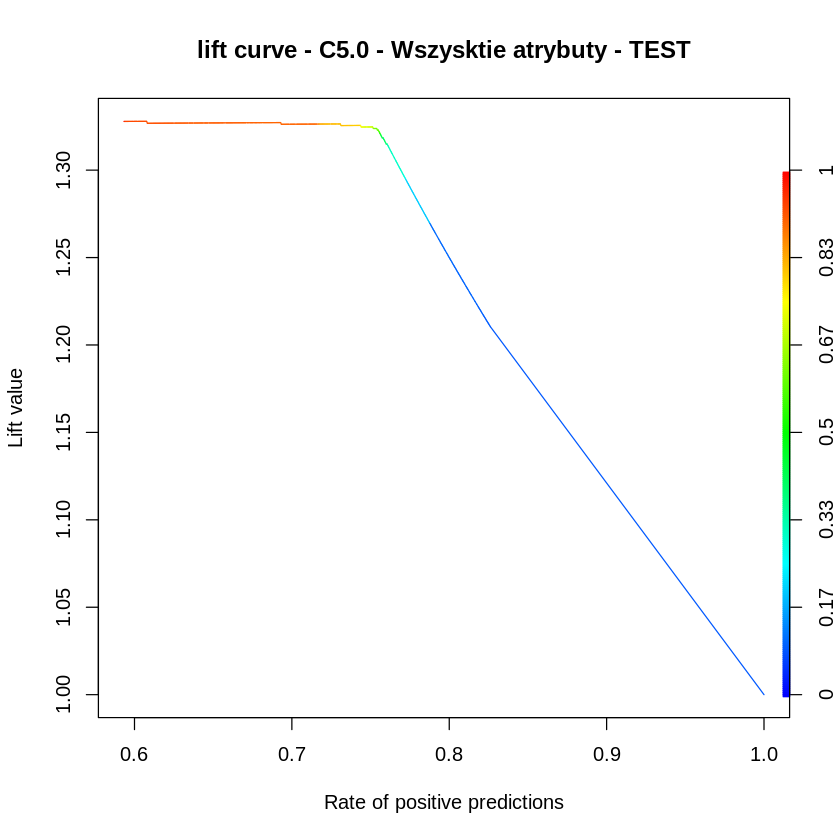

In [11]:

#hist(wines)

#
# I. Eksploracja z algorytem C5.0
#

#
# 1. C5.0 - Proba - wszytkie atrybuty 
#

train_test = split_train_test(wines_orginal, 0.7)

train = train_test$train
test = train_test$test

#  WSZYSTKIE ATRYBUTY
mod_c5 <- C5.0(class ~ ., data = train,trials = 10, rules = TRUE)
summary(mod_c5)

# Pokaze tablice pomylek i statystyki
cm = model_stats(mod_c5, test)
draw_roc_lift(mod_c5, test, "C5.0 - Wszysktie atrybuty - TEST")

desc = c(try_num=next_try(),desc='Wszytkie atrybuty:', tree_type = 'C5.0', type='test')
desc= append(desc, cm$byClass)
desc = append(desc, cm$overall)
results = data.frame(t(desc),stringsAsFactors = FALSE)



# WNIOSKI: Czesc atrybutow ma mniejsze znaczenie w drzewie. Atrybut quality nie jest wykorzystywany.
#          W nastepnych proboba zrezygnuje z czesci atrybutow


In [12]:

#
# 2.  Redukuje pokolei atrytuty z summary(mod_c5) z najmniejszym wykorzystaniem
#      i obliczam maciez pomylek oraz statystyki modelu dla zbioru testowego.
#
wines = subset(wines_orginal, select=-c(quality, density, alcohol, free.sulfur.dioxide, fixed.acidity, pH, citric.acid))

train_test = split_train_test(wines, 0.7)
train = train_test$train
test = train_test$test

mod_c5 <- C5.0(class ~ ., data = train,trials = 10, rules = TRUE)
summary(mod_c5)


Call:
C5.0.formula(formula = class ~ ., data = train, trials = 10, rules = TRUE)


C5.0 [Release 2.07 GPL Edition]  	Tue Oct 20 21:22:58 2020
-------------------------------

Class specified by attribute `outcome'

Read 4547 cases (6 attributes) from undefined.data

-----  Trial 0:  -----

Rules:

Rule 0/1: (712, lift 4.1)
	chlorides > 0.048
	total.sulfur.dioxide <= 52
	sulphates > 0.46
	->  class R  [0.999]

Rule 0/2: (599/1, lift 4.1)
	volatile.acidity > 0.38
	residual.sugar > 1.55
	chlorides > 0.067
	total.sulfur.dioxide <= 148
	sulphates > 0.5
	->  class R  [0.997]

Rule 0/3: (259, lift 4.1)
	volatile.acidity > 0.575
	residual.sugar <= 2.65
	total.sulfur.dioxide <= 70
	sulphates > 0.41
	->  class R  [0.996]

Rule 0/4: (468/1, lift 4.1)
	residual.sugar > 1.7
	total.sulfur.dioxide <= 61
	sulphates > 0.58
	->  class R  [0.996]

Rule 0/5: (459/1, lift 4.1)
	volatile.acidity > 0.345
	total.sulfur.dioxide <= 70
	sulphates > 0.58
	->  class R  [0.996]

Rule 0/6: (834/2, lift 4.1)
	volati

          Reference
Prediction    R    W
         R  471   13
         W    9 1457
      Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
      9.89e-01       9.70e-01       9.83e-01       9.93e-01       7.54e-01 
AccuracyPValue  McnemarPValue 
     2.00e-199       5.22e-01 
         Sensitivity          Specificity       Pos Pred Value 
               0.981                0.991                0.973 
      Neg Pred Value            Precision               Recall 
               0.994                0.973                0.981 
                  F1           Prevalence       Detection Rate 
               0.977                0.246                0.242 
Detection Prevalence    Balanced Accuracy 
               0.248                0.986 


Setting levels: control = R, case = W

Setting direction: controls > cases



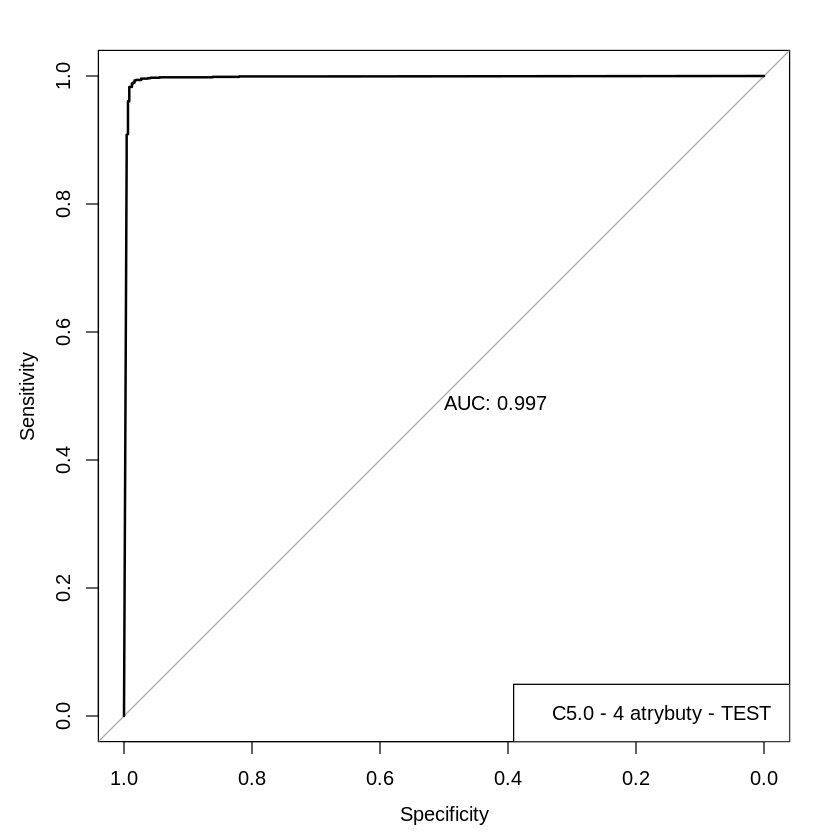

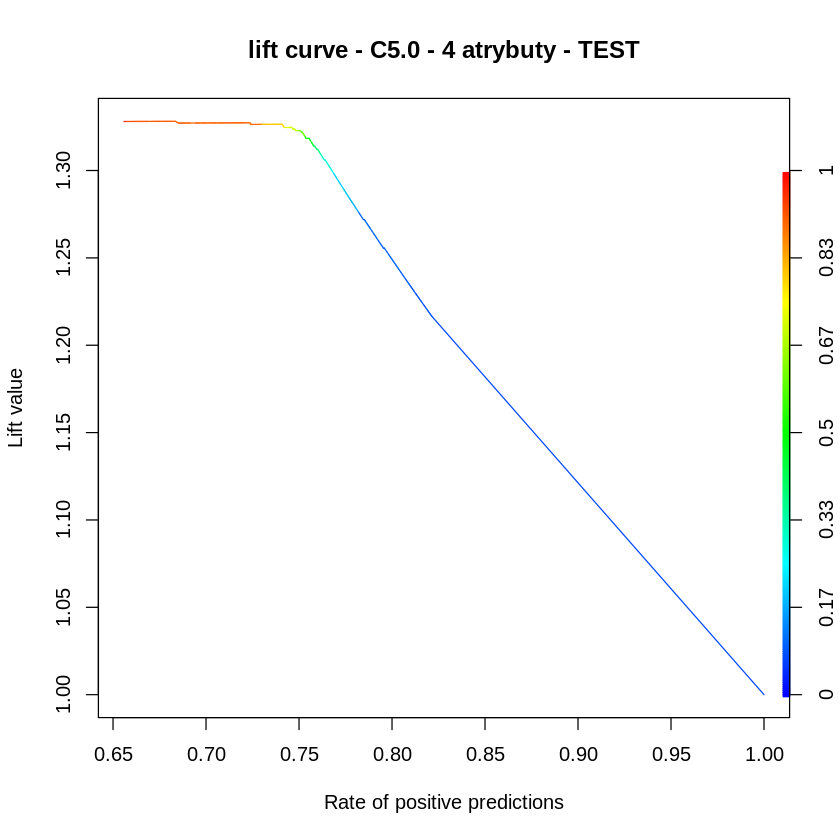

In [15]:
# Pokaze tablice pomylek i statystyki
cm = model_stats(mod_c5, test)
draw_roc_lift(mod_c5, test, "C5.0 - 4 atrybuty - TEST")
results = store_cm(results, cm, c(try_num=next_try(),desc='5 atrybutow', tree_type = 'C5.0', type='test') )

#View(results)

# WNIOSKI: Statystyki modelu spadly o ok 1% procent, zmniejsze ilosc parametrow, 
#           aby sprawdzic czy moze wystarczy ich jeszce mniej.



In [16]:

# A. Jeden atrybut: chlorides

wines = subset(wines_orginal, select= c(chlorides, class))


train_test = split_train_test(wines, 0.7)
train = train_test$train
test = train_test$test

mod_c5 <- C5.0(class ~ ., data = train,trials = 10, rules = TRUE)
summary(mod_c5)


Call:
C5.0.formula(formula = class ~ ., data = train, trials = 10, rules = TRUE)


C5.0 [Release 2.07 GPL Edition]  	Tue Oct 20 21:23:59 2020
-------------------------------

Class specified by attribute `outcome'

Read 4547 cases (2 attributes) from undefined.data

-----  Trial 0:  -----

Rules:

Rule 0/1: (1252/254, lift 3.2)
	chlorides > 0.06
	->  class R  [0.797]

Rule 0/2: (3295/117, lift 1.3)
	chlorides <= 0.06
	->  class W  [0.964]

Default class: W

-----  Trial 1:  -----

Rules:

Default class: W

*** boosting reduced to 1 trial since last classifier is very inaccurate

*** boosting abandoned (too few classifiers)


Evaluation on training data (4547 cases):

	        Rules     
	  ----------------
	    No      Errors

	     2  371( 8.2%)   <<


	   (a)   (b)    <-classified as
	  ----  ----
	   998   117    (a): class R
	   254  3178    (b): class W


	Attribute usage:

	100.00%	chlorides


Time: 0.0 secs


          Reference
Prediction    R    W
         R  436   48
         W  109 1357
      Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
      9.19e-01       7.93e-01       9.07e-01       9.31e-01       7.21e-01 
AccuracyPValue  McnemarPValue 
     4.02e-107       1.68e-06 
         Sensitivity          Specificity       Pos Pred Value 
               0.800                0.966                0.901 
      Neg Pred Value            Precision               Recall 
               0.926                0.901                0.800 
                  F1           Prevalence       Detection Rate 
               0.847                0.279                0.224 
Detection Prevalence    Balanced Accuracy 
               0.248                0.883 


Setting levels: control = R, case = W

Setting direction: controls > cases



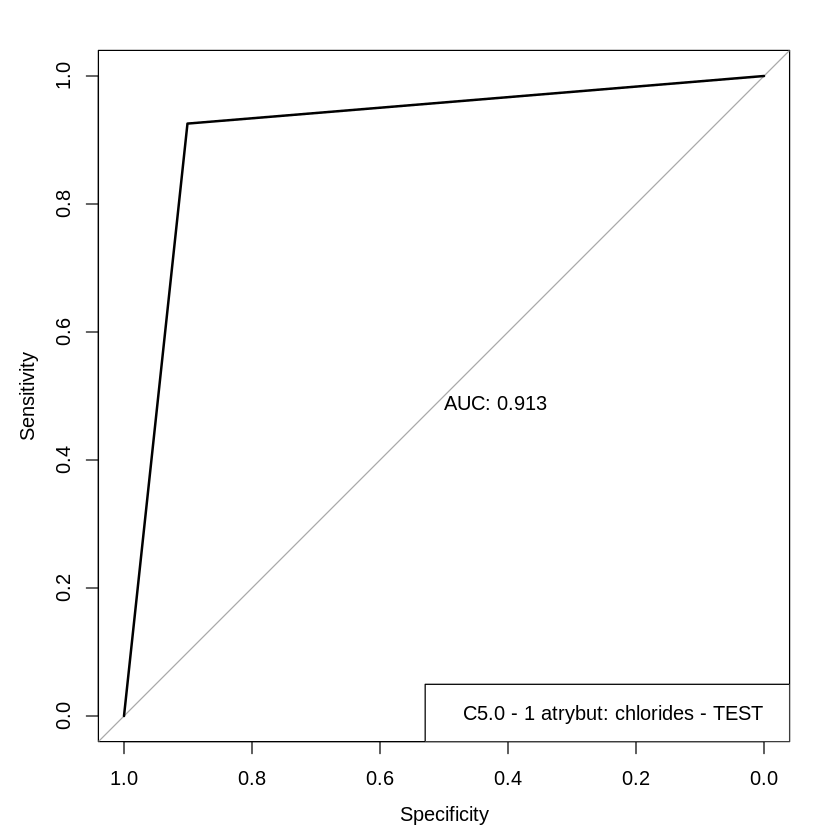

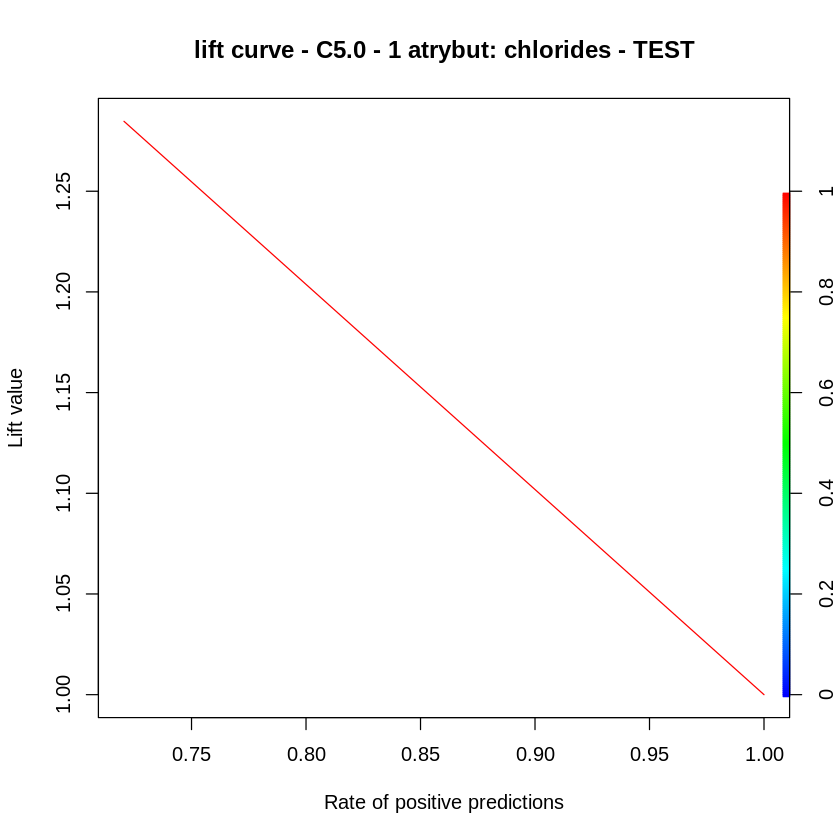

In [17]:

# Pokaze tablice pomylek i statystyki
cm = model_stats(mod_c5, test)
results = store_cm(results, cm, c(try_num=next_try(),desc='1 atrybut - chlorides', tree_type = 'C5.0', type='test') )
draw_roc_lift(mod_c5, test, "C5.0 - 1 atrybut: chlorides - TEST")



In [18]:

# B. Jeden atrybut: total.sulfur.dioxide

wines = subset(wines_orginal, select= c(total.sulfur.dioxide, class))


train_test = split_train_test(wines, 0.7)
train = train_test$train
test = train_test$test

mod_c5 <- C5.0(class ~ ., data = train,trials = 10, rules = TRUE)
summary(mod_c5)


Call:
C5.0.formula(formula = class ~ ., data = train, trials = 10, rules = TRUE)


C5.0 [Release 2.07 GPL Edition]  	Tue Oct 20 21:25:46 2020
-------------------------------

Class specified by attribute `outcome'

Read 4547 cases (2 attributes) from undefined.data

-----  Trial 0:  -----

Rules:

Rule 0/1: (1033/131, lift 3.6)
	total.sulfur.dioxide <= 70
	->  class R  [0.872]

Rule 0/2: (3514/213, lift 1.2)
	total.sulfur.dioxide > 70
	->  class W  [0.939]

Default class: W

-----  Trial 1:  -----

Rules:

Rule 1/1: (2291.8/1026.2, lift 1.7)
	total.sulfur.dioxide <= 106
	->  class R  [0.552]

Rule 1/2: (2255.2/239.7, lift 1.3)
	total.sulfur.dioxide > 106
	->  class W  [0.893]

Default class: W

-----  Trial 2:  -----

Rules:

Rule 2/1: (630.3/144.5, lift 2.6)
	total.sulfur.dioxide <= 50
	->  class R  [0.770]

Rule 2/2: (3916.7/861.2, lift 1.1)
	total.sulfur.dioxide > 50
	->  class W  [0.780]

Default class: W

-----  Trial 3:  -----

Rules:

Rule 3/1: (2162.7/901.6, lift 1.4)
	total.s

          Reference
Prediction    R    W
         R  386   98
         W   43 1423
      Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
      9.28e-01       7.99e-01       9.15e-01       9.39e-01       7.80e-01 
AccuracyPValue  McnemarPValue 
      3.84e-70       5.43e-06 
         Sensitivity          Specificity       Pos Pred Value 
               0.900                0.936                0.798 
      Neg Pred Value            Precision               Recall 
               0.971                0.798                0.900 
                  F1           Prevalence       Detection Rate 
               0.846                0.220                0.198 
Detection Prevalence    Balanced Accuracy 
               0.248                0.918 


Setting levels: control = R, case = W

Setting direction: controls > cases



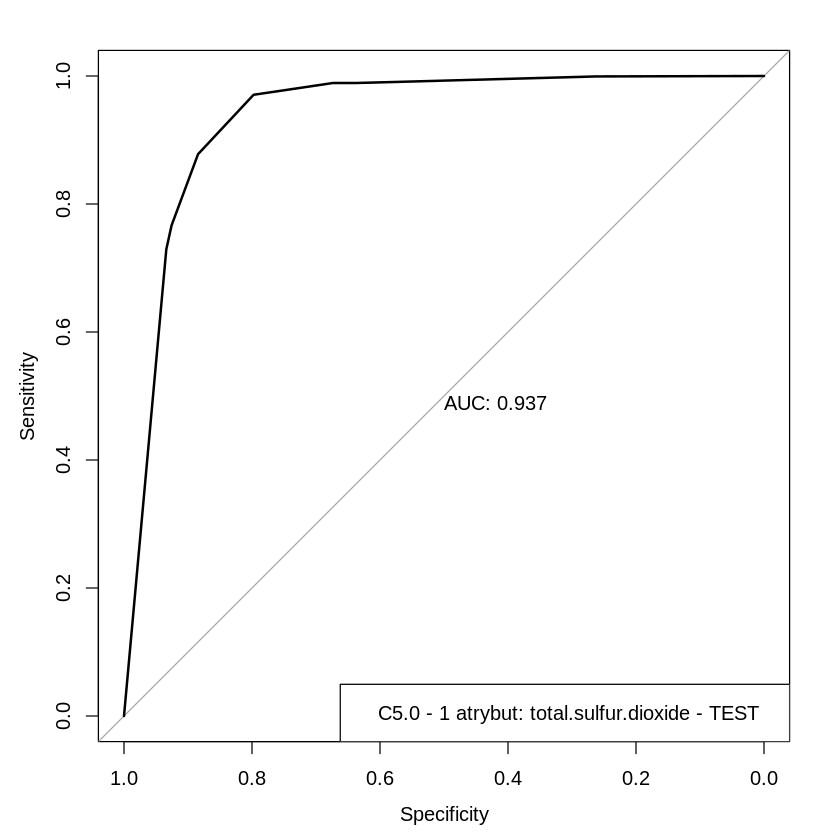

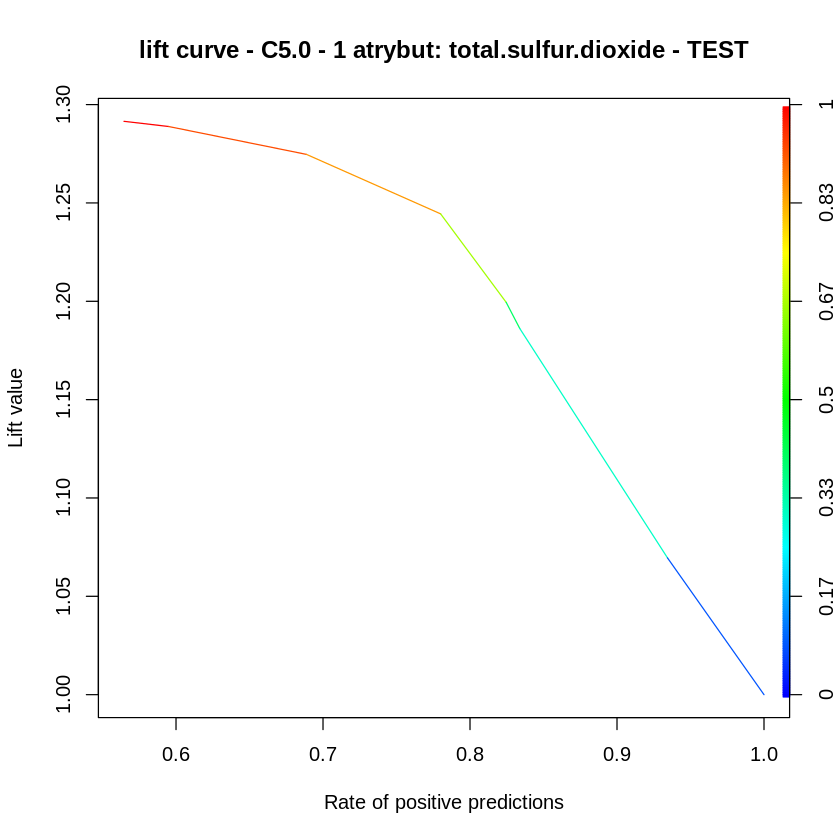

In [19]:


# Pokaze tablice pomylek i statystyki
cm = model_stats(mod_c5, test)
results = store_cm(results, cm, c(try_num=next_try(),desc='1 atrybut - total.sulfur.dioxide', tree_type = 'C5.0', type='test') )
draw_roc_lift(mod_c5, test, "C5.0 - 1 atrybut: total.sulfur.dioxide - TEST")


In [20]:
# C. 2 - atrybuty chlorides, total.sulfur.dioxide

wines = subset(wines_orginal, select= c(chlorides, total.sulfur.dioxide, class))
#wines = subset(wines_orginal, select= c(chlorides, class))


train_test = split_train_test(wines, 0.7)
train = train_test$train
test = train_test$test

mod_c5 <- C5.0(class ~ ., data = train,trials = 10, rules = TRUE)
summary(mod_c5)



Call:
C5.0.formula(formula = class ~ ., data = train, trials = 10, rules = TRUE)


C5.0 [Release 2.07 GPL Edition]  	Tue Oct 20 21:26:39 2020
-------------------------------

Class specified by attribute `outcome'

Read 4547 cases (3 attributes) from undefined.data

-----  Trial 0:  -----

Rules:

Rule 0/1: (358, lift 4.1)
	chlorides > 0.037
	total.sulfur.dioxide <= 25
	->  class R  [0.997]

Rule 0/2: (781/5, lift 4.0)
	chlorides > 0.047
	total.sulfur.dioxide <= 54
	->  class R  [0.992]

Rule 0/3: (897/13, lift 4.0)
	chlorides > 0.048
	total.sulfur.dioxide <= 70
	->  class R  [0.984]

Rule 0/4: (819/19, lift 4.0)
	chlorides > 0.067
	total.sulfur.dioxide <= 95
	->  class R  [0.976]

Rule 0/5: (785/22, lift 4.0)
	chlorides > 0.067
	chlorides <= 0.112
	total.sulfur.dioxide <= 122
	->  class R  [0.971]

Rule 0/6: (763/35, lift 3.9)
	chlorides > 0.07
	chlorides <= 0.112
	total.sulfur.dioxide <= 148
	->  class R  [0.953]

Rule 0/7: (1107/3, lift 1.3)
	chlorides <= 0.037
	->  class W  [0.996

          Reference
Prediction    R    W
         R  443   41
         W   13 1453
      Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
      9.72e-01       9.24e-01       9.64e-01       9.79e-01       7.66e-01 
AccuracyPValue  McnemarPValue 
     4.02e-148       2.39e-04 
         Sensitivity          Specificity       Pos Pred Value 
               0.971                0.973                0.915 
      Neg Pred Value            Precision               Recall 
               0.991                0.915                0.971 
                  F1           Prevalence       Detection Rate 
               0.943                0.234                0.227 
Detection Prevalence    Balanced Accuracy 
               0.248                0.972 


Setting levels: control = R, case = W

Setting direction: controls > cases



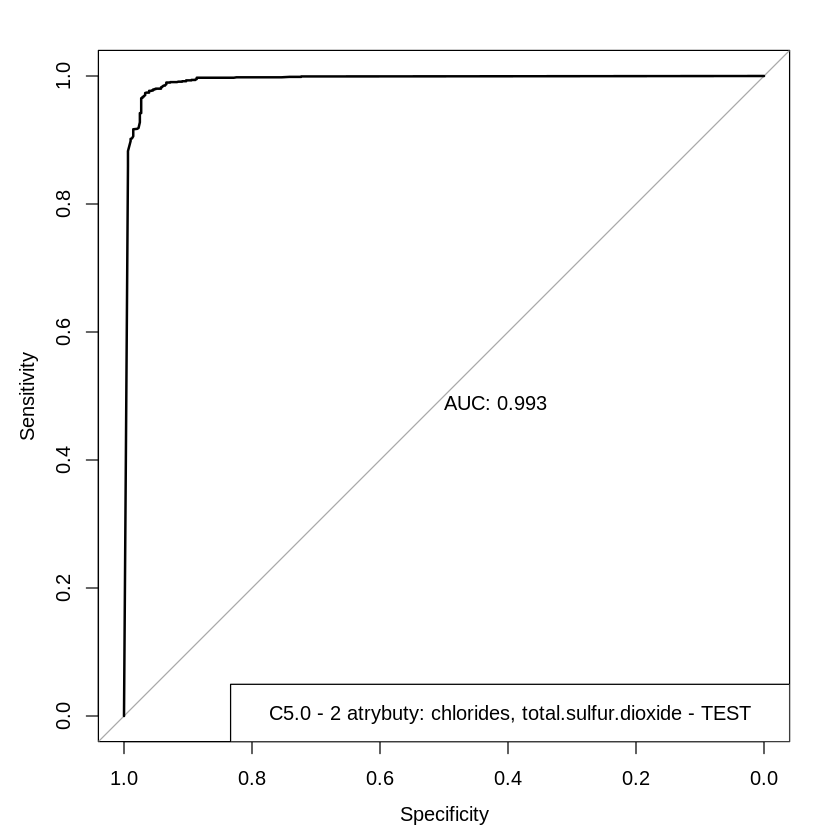

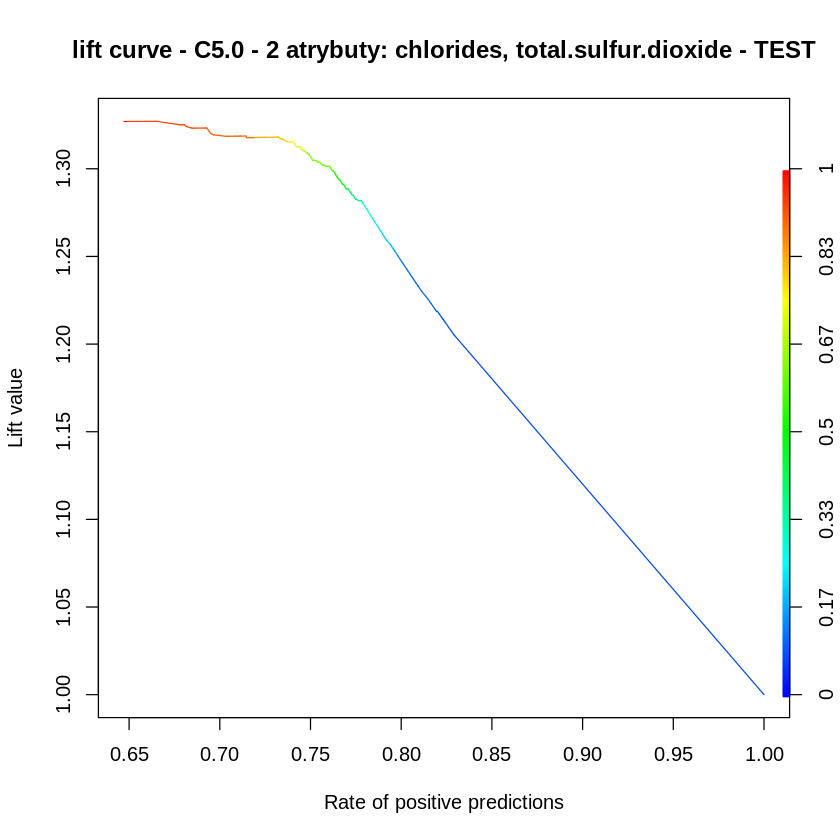

In [21]:

# Pokaze tablice pomylek i statystyki
cm = model_stats(mod_c5, test)
results = store_cm(results, cm, c(try_num=next_try(),desc='2 atrybuty - chlorides, total.sulfur.dioxide, class', tree_type = 'C5.0', type='test') )
draw_roc_lift(mod_c5, test, "C5.0 - 2 atrybuty: chlorides, total.sulfur.dioxide - TEST")

#View(results)

# WNIOSKI: Z 2.A i 2.B wynika ze tyle pojedynczy atrybut zmniejsza istotnie sprawnosc modelu na danych testowych.
#          Z tego wynika, ze o kolorze wina decytuje glownie zawartosc 2 substancji: chlorides, total.sulfur.dioxide.
#          Aby uzyskac wysoka i Czulosc (Sensitivity, TPR) i Swoistosc (Specificity, TNR) > 0.8 trzeba 
#          rozwac oba z ww. atrybutow.
#  
# 


Call:
C5.0.formula(formula = class ~ ., data = train, trials = 10, rules = TRUE)


C5.0 [Release 2.07 GPL Edition]  	Tue Oct 20 21:00:25 2020
-------------------------------

Class specified by attribute `outcome'

Read 4547 cases (13 attributes) from undefined.data

-----  Trial 0:  -----

Rules:

Rule 0/1: (825, lift 4.1)
	chlorides > 0.048
	total.sulfur.dioxide <= 70
	density > 0.99323
	sulphates > 0.46
	->  class R  [0.999]

Rule 0/2: (807, lift 4.1)
	volatile.acidity > 0.275
	residual.sugar <= 5.35
	chlorides > 0.048
	total.sulfur.dioxide <= 70
	->  class R  [0.999]

Rule 0/3: (367, lift 4.1)
	total.sulfur.dioxide <= 70
	density > 0.99379
	sulphates > 0.65
	->  class R  [0.997]

Rule 0/4: (250, lift 4.1)
	volatile.acidity > 0.22
	residual.sugar > 1.15
	total.sulfur.dioxide <= 70
	pH > 3.39
	->  class R  [0.996]

Rule 0/5: (259/1, lift 4.0)
	fixed.acidity > 9.1
	chlorides > 0.067
	->  class R  [0.992]

Rule 0/6: (19, lift 3.9)
	volatile.acidity > 0.47
	pH > 3.62
	->  class R  [0.9

          Reference
Prediction    R    W
         R  474   10
         W    2 1464
      Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
      9.94e-01       9.83e-01       9.89e-01       9.97e-01       7.56e-01 
AccuracyPValue  McnemarPValue 
     8.05e-213       4.33e-02 
         Sensitivity          Specificity       Pos Pred Value 
               0.996                0.993                0.979 
      Neg Pred Value            Precision               Recall 
               0.999                0.979                0.996 
                  F1           Prevalence       Detection Rate 
               0.988                0.244                0.243 
Detection Prevalence    Balanced Accuracy 
               0.248                0.995 


Setting levels: control = R, case = W

Setting direction: controls > cases



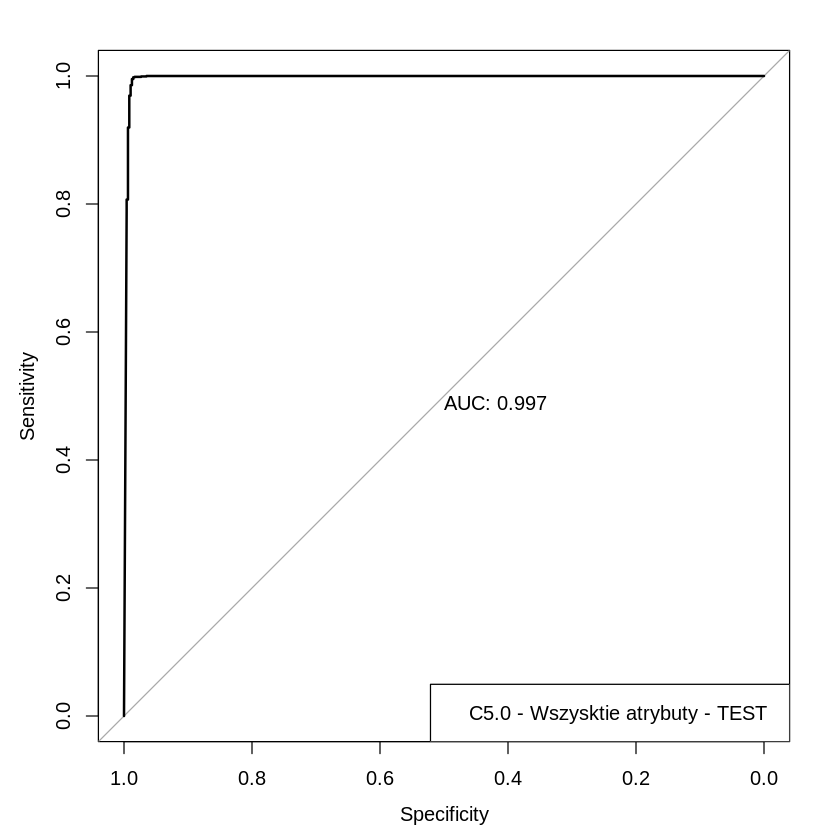


Call:
C5.0.formula(formula = class ~ ., data = train, trials = 10, rules = TRUE)


C5.0 [Release 2.07 GPL Edition]  	Tue Oct 20 21:00:26 2020
-------------------------------

Class specified by attribute `outcome'

Read 4547 cases (6 attributes) from undefined.data

-----  Trial 0:  -----

Rules:

Rule 0/1: (712, lift 4.1)
	chlorides > 0.048
	total.sulfur.dioxide <= 52
	sulphates > 0.46
	->  class R  [0.999]

Rule 0/2: (599/1, lift 4.1)
	volatile.acidity > 0.38
	residual.sugar > 1.55
	chlorides > 0.067
	total.sulfur.dioxide <= 148
	sulphates > 0.5
	->  class R  [0.997]

Rule 0/3: (259, lift 4.1)
	volatile.acidity > 0.575
	residual.sugar <= 2.65
	total.sulfur.dioxide <= 70
	sulphates > 0.41
	->  class R  [0.996]

Rule 0/4: (468/1, lift 4.1)
	residual.sugar > 1.7
	total.sulfur.dioxide <= 61
	sulphates > 0.58
	->  class R  [0.996]

Rule 0/5: (459/1, lift 4.1)
	volatile.acidity > 0.345
	total.sulfur.dioxide <= 70
	sulphates > 0.58
	->  class R  [0.996]

Rule 0/6: (834/2, lift 4.1)
	volati

          Reference
Prediction    R    W
         R  471   13
         W    9 1457
      Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
      9.89e-01       9.70e-01       9.83e-01       9.93e-01       7.54e-01 
AccuracyPValue  McnemarPValue 
     2.00e-199       5.22e-01 
         Sensitivity          Specificity       Pos Pred Value 
               0.981                0.991                0.973 
      Neg Pred Value            Precision               Recall 
               0.994                0.973                0.981 
                  F1           Prevalence       Detection Rate 
               0.977                0.246                0.242 
Detection Prevalence    Balanced Accuracy 
               0.248                0.986 


Setting levels: control = R, case = W

Setting direction: controls > cases



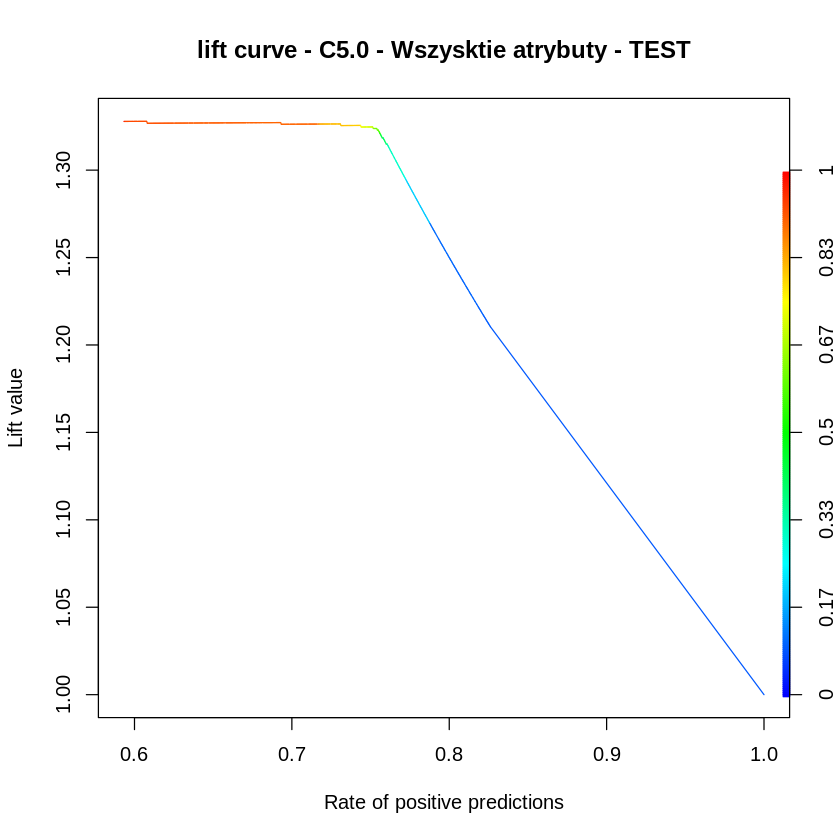

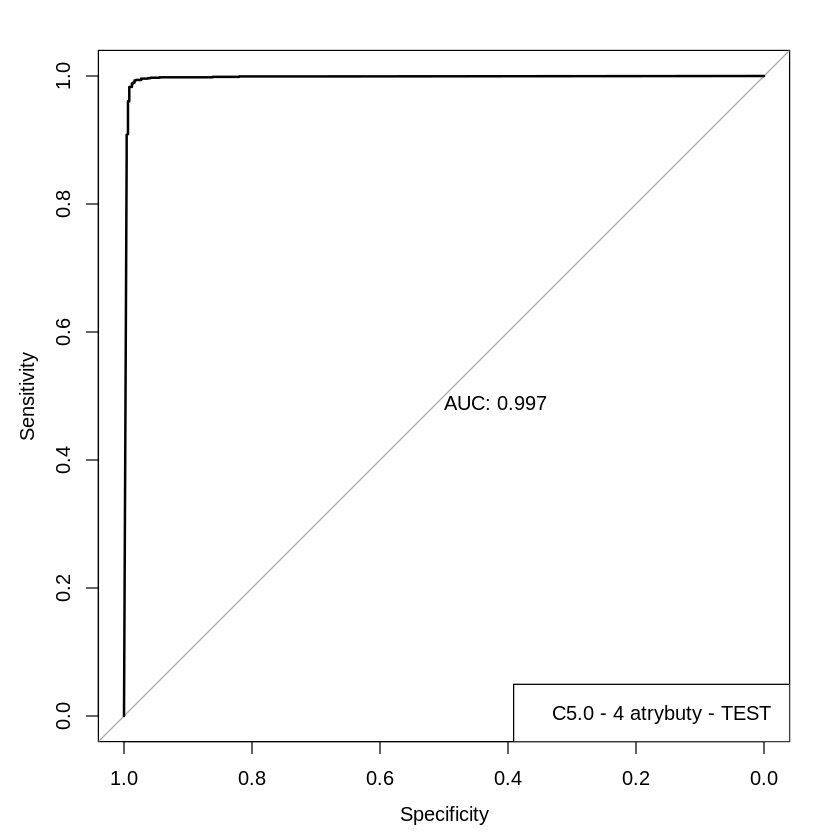

ERROR: ignored

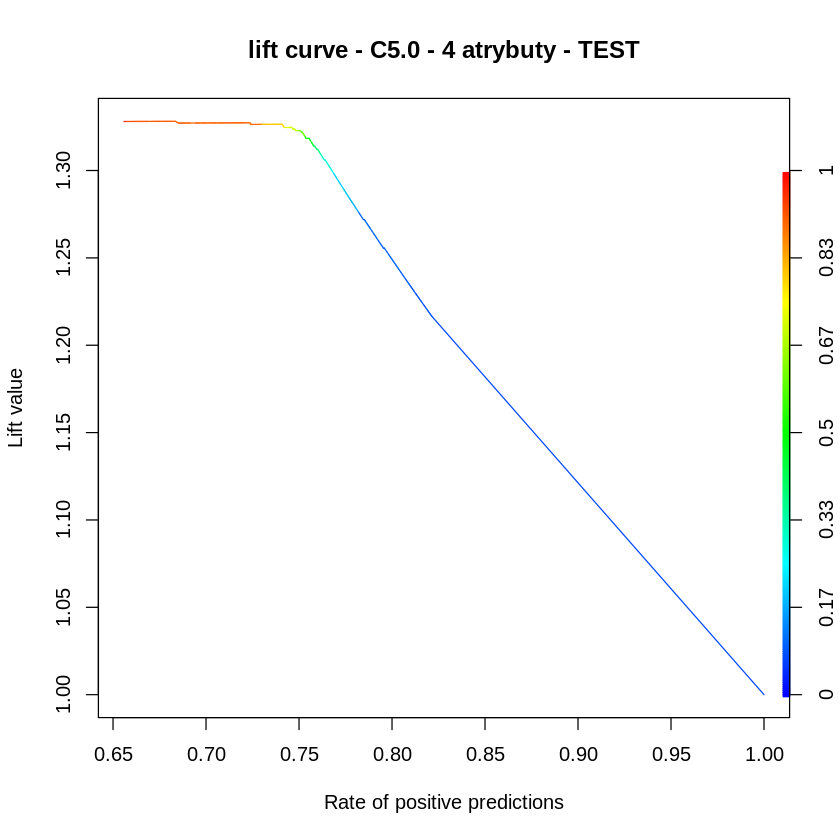

In [6]:


#
# II. Budowanie drzwa uzyciem rpart 
# 

#
#  1. Uzycie wszystkich atrybutow o
#
wines = subset(wines_orginal, select= c(chlorides, total.sulfur.dioxide, class))
#wines = subset(wines_orginal, select= c(chlorides, class))

train_test = split_train_test(wines, 0.7)
train = train_test$train
test = train_test$test

#myFormula = class ~ total.sulfur.dioxide + alcohol
rpTree <- rpart(class ~ .,  method="class", data=train)

#rpTree <- rpart(myFormula,  method="class", data=train)
rpTree
plot(rpTree)

rpart.plot(rpTree)
summary(rpTree)

# Pokaze tablice pomylek i statystyki
cm = model_stats(rpTree, test)
draw_roc_lift(rpTree, test, "Wszytkie atrybuty - zb. testowy")

results = store_cm(results, cm, c(try_num=next_try(),desc='2 atrybuty - chlorides, total.sulfur.dioxide, class', tree_type = 'rpTree', type='test') )

#View(results)


Call:
rpart(formula = class ~ ., data = train, method = "class")
  n= 4547 

      CP nsplit rel error xerror    xstd
1 0.6924      0    1.0000  1.000 0.02602
2 0.0870      1    0.3076  0.340 0.01672
3 0.0547      2    0.2206  0.243 0.01432
4 0.0395      4    0.1112  0.151 0.01141
5 0.0100      5    0.0717  0.110 0.00981

Variable importance
total.sulfur.dioxide            chlorides  free.sulfur.dioxide 
                  33                   22                   12 
    volatile.acidity        fixed.acidity          citric.acid 
                  10                    8                    6 
             density       residual.sugar            sulphates 
                   4                    3                    2 

Node number 1: 4547 observations,    complexity param=0.692
  predicted class=W  expected loss=0.245  P(node) =1
    class counts:  1115  3432
   probabilities: 0.245 0.755 
  left son=2 (1022 obs) right son=3 (3525 obs)
  Primary splits:
      total.sulfur.dioxide < 69.

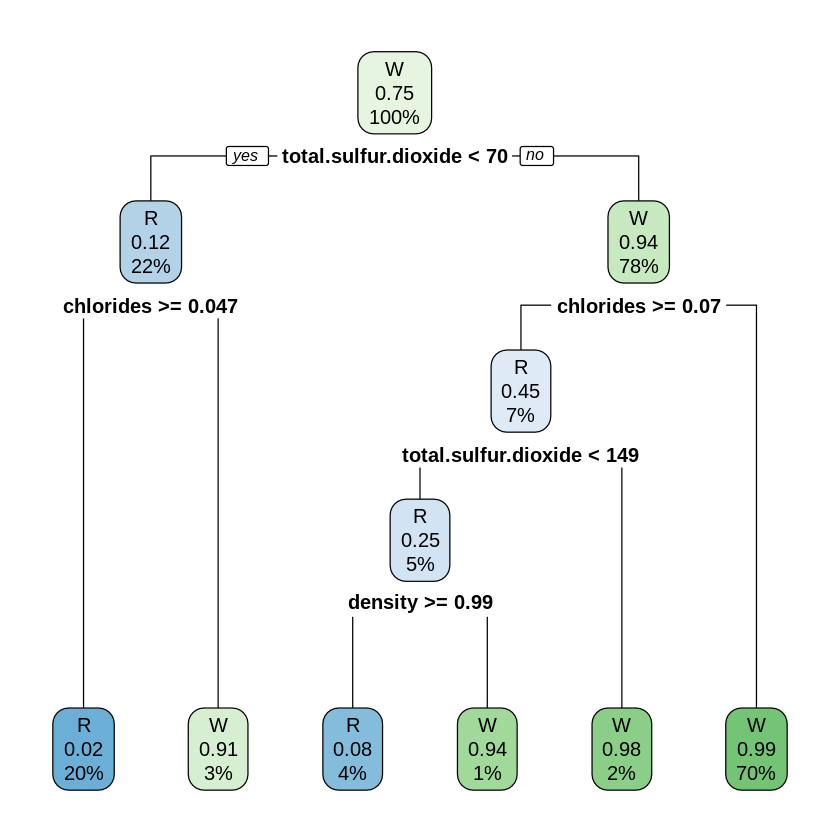

In [23]:

#
# rPart PRUNNING
#

#wines = subset(wines_orginal, select= c(chlorides, total.sulfur.dioxide, class))
#wines = subset(wines_orginal, select= c(chlorides, class))
wines = wines_orginal

train_test = split_train_test(wines, 0.7)
train = train_test$train
test = train_test$test

#myFormula = class ~ total.sulfur.dioxide + alcohol
rpTree <- rpart(class ~ .,  method="class", data=train)

rpart.plot(rpTree)
summary(rpTree)

# Pokaze tablice pomylek i statystyki
cm = model_stats(rpTree, test)
results = store_cm(results, cm, c(try_num=next_try(),desc='Wszystkie - przed przycinaniem', tree_type = 'rpTree', type='test') )


Call:
rpart(formula = class ~ ., data = train, method = "class")
  n= 4547 

      CP nsplit rel error xerror    xstd
1 0.6924      0    1.0000  1.000 0.02602
2 0.0870      1    0.3076  0.340 0.01672
3 0.0547      2    0.2206  0.243 0.01432
4 0.0395      4    0.1112  0.151 0.01141
5 0.0100      5    0.0717  0.110 0.00981

Variable importance
total.sulfur.dioxide            chlorides  free.sulfur.dioxide 
                  33                   22                   12 
    volatile.acidity        fixed.acidity          citric.acid 
                  10                    8                    6 
             density       residual.sugar            sulphates 
                   4                    3                    2 

Node number 1: 4547 observations,    complexity param=0.692
  predicted class=W  expected loss=0.245  P(node) =1
    class counts:  1115  3432
   probabilities: 0.245 0.755 
  left son=2 (1022 obs) right son=3 (3525 obs)
  Primary splits:
      total.sulfur.dioxide < 69.

1     2     3     4     5 
1.000 0.340 0.243 0.151 0.110

[1] 0.11

5 
5

[1] 0.0547

Call:
rpart(formula = class ~ ., data = train, method = "class")
  n= 4547 

      CP nsplit rel error xerror    xstd
1 0.6924      0    1.0000  1.000 0.02602
2 0.0870      1    0.3076  0.340 0.01672
3 0.0547      2    0.2206  0.243 0.01432
4 0.0395      4    0.1112  0.151 0.01141
5 0.0100      5    0.0717  0.110 0.00981

Variable importance
total.sulfur.dioxide            chlorides  free.sulfur.dioxide 
                  33                   22                   12 
    volatile.acidity        fixed.acidity          citric.acid 
                  10                    8                    6 
             density       residual.sugar            sulphates 
                   4                    3                    2 

Node number 1: 4547 observations,    complexity param=0.692
  predicted class=W  expected loss=0.245  P(node) =1
    class counts:  1115  3432
   probabilities: 0.245 0.755 
  left son=2 (1022 obs) right son=3 (3525 obs)
  Primary splits:
      total.sulfur.dioxide < 69.

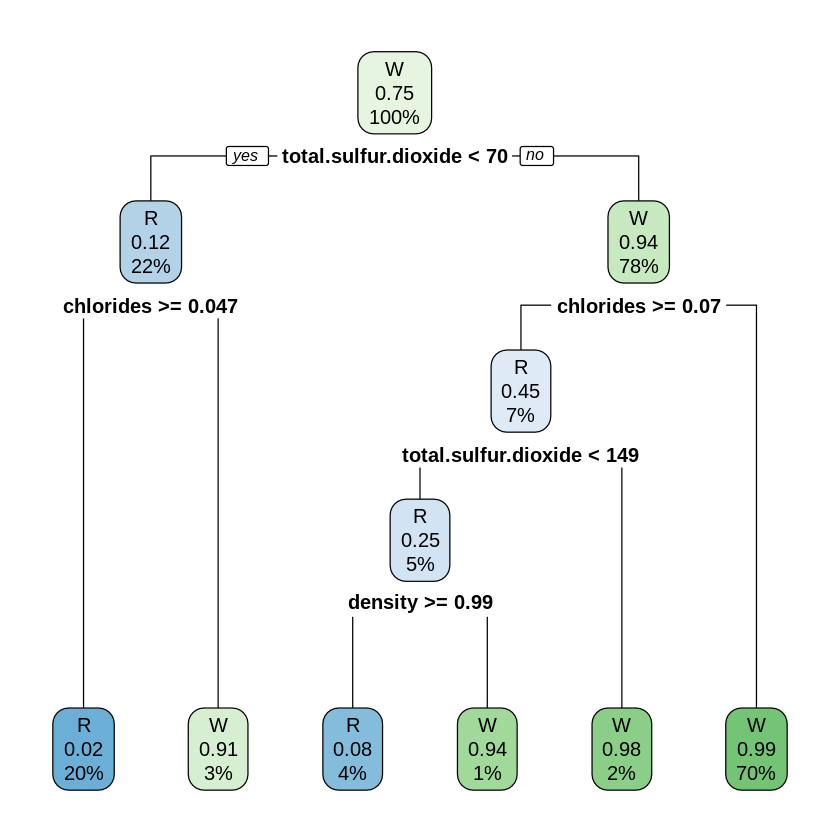

In [25]:

#View(results)

# prunning
summary(rpTree)
rpTree$cptable[,"xerror"]
min(rpTree$cptable[,"xerror"])
which.min(rpTree$cptable[,"xerror"])
rpTree.cp=rpTree$cptable[3,"CP"]
rpTree.cp
#?prune

rpart.plot(rpTree)
summary(rpTree)


[1] "Przycinanie, rpart, cp=1.00, test"
          Reference
Prediction    R    W
         R    0  484
         W    0 1466
      Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
      7.52e-01       0.00e+00       7.32e-01       7.71e-01       1.00e+00 
AccuracyPValue  McnemarPValue 
      1.00e+00      7.84e-107 
         Sensitivity          Specificity       Pos Pred Value 
                  NA                0.752                   NA 
      Neg Pred Value            Precision               Recall 
                  NA                0.000                   NA 
                  F1           Prevalence       Detection Rate 
                  NA                0.000                0.000 
Detection Prevalence    Balanced Accuracy 
               0.248                   NA 
[1] "Przycinanie, rpart, cp=0.34, test"
          Reference
Prediction    R    W
         R  383  101
         W   41 1425
      Accuracy          Kappa  AccuracyLower  AccuracyUpper   Accuracy

Setting levels: control = R, case = W

Setting direction: controls > cases



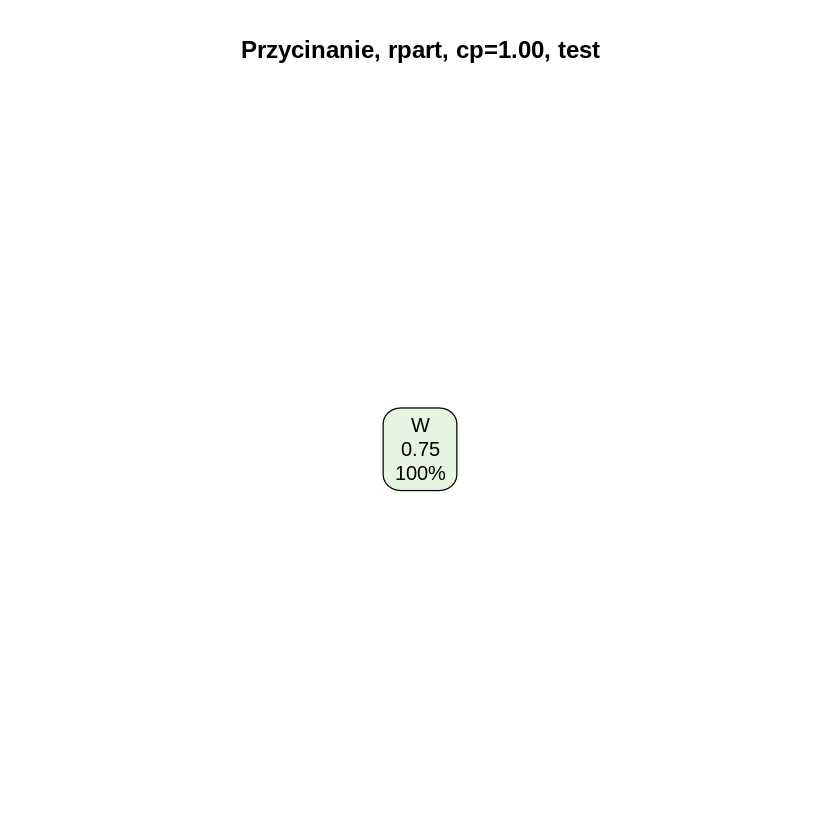

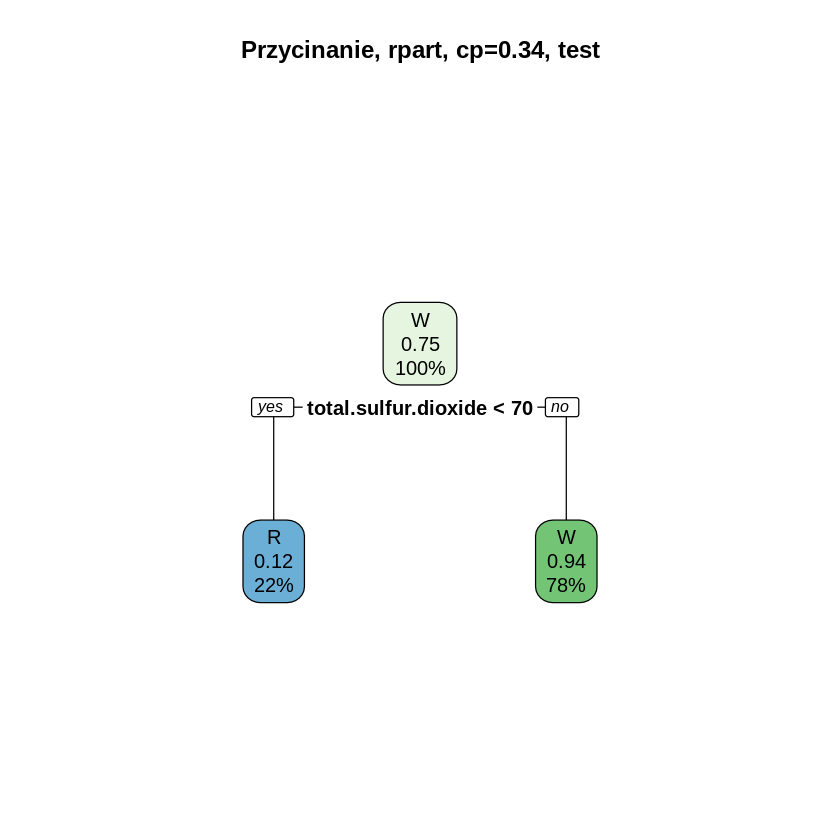

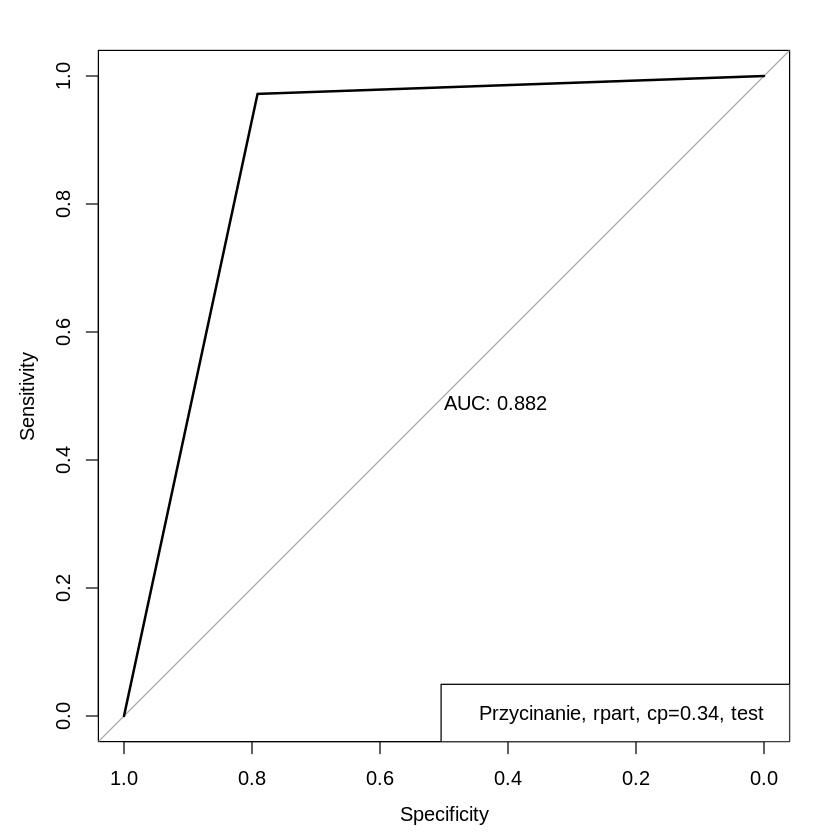

[1] "Przycinanie, rpart, cp=0.24, test"
          Reference
Prediction    R    W
         R  383  101
         W   41 1425
      Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
      9.27e-01       7.96e-01       9.15e-01       9.38e-01       7.83e-01 
AccuracyPValue  McnemarPValue 
      9.94e-68       7.38e-07 
         Sensitivity          Specificity       Pos Pred Value 
               0.903                0.934                0.791 
      Neg Pred Value            Precision               Recall 
               0.972                0.791                0.903 
                  F1           Prevalence       Detection Rate 
               0.844                0.217                0.196 
Detection Prevalence    Balanced Accuracy 
               0.248                0.919 


Setting levels: control = R, case = W

Setting direction: controls > cases



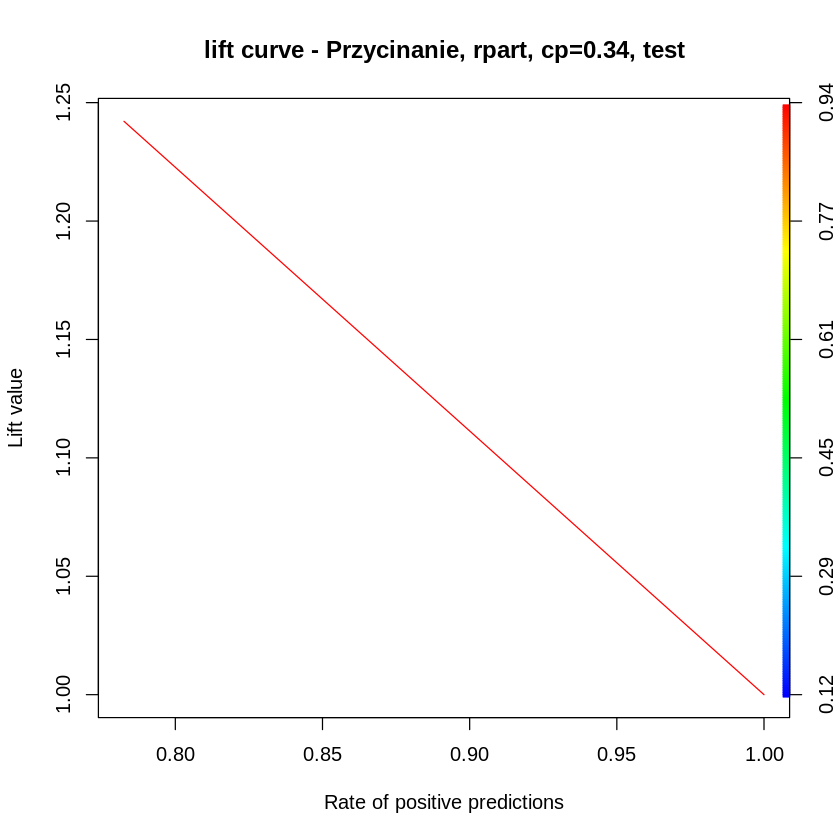

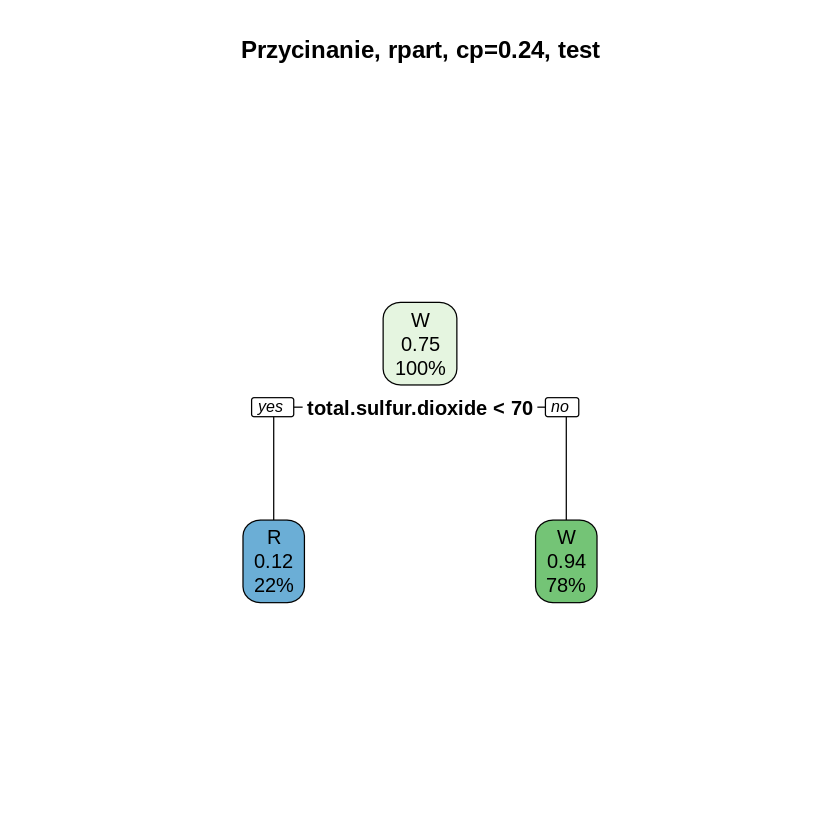

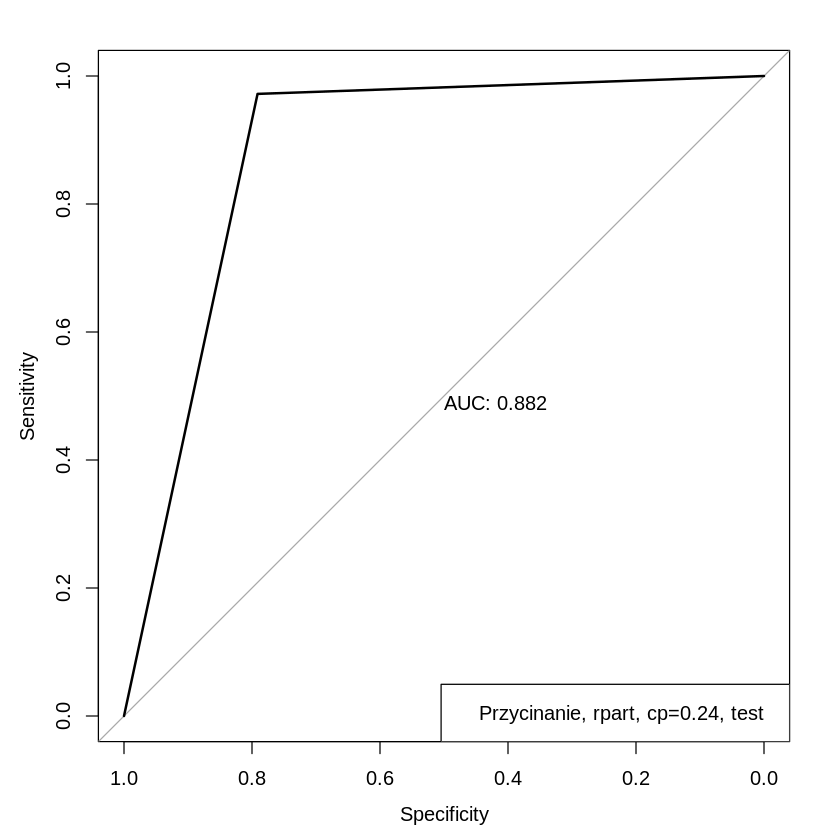

[1] "Przycinanie, rpart, cp=0.15, test"
          Reference
Prediction    R    W
         R  383  101
         W   41 1425
      Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
      9.27e-01       7.96e-01       9.15e-01       9.38e-01       7.83e-01 
AccuracyPValue  McnemarPValue 
      9.94e-68       7.38e-07 
         Sensitivity          Specificity       Pos Pred Value 
               0.903                0.934                0.791 
      Neg Pred Value            Precision               Recall 
               0.972                0.791                0.903 
                  F1           Prevalence       Detection Rate 
               0.844                0.217                0.196 
Detection Prevalence    Balanced Accuracy 
               0.248                0.919 


Setting levels: control = R, case = W

Setting direction: controls > cases



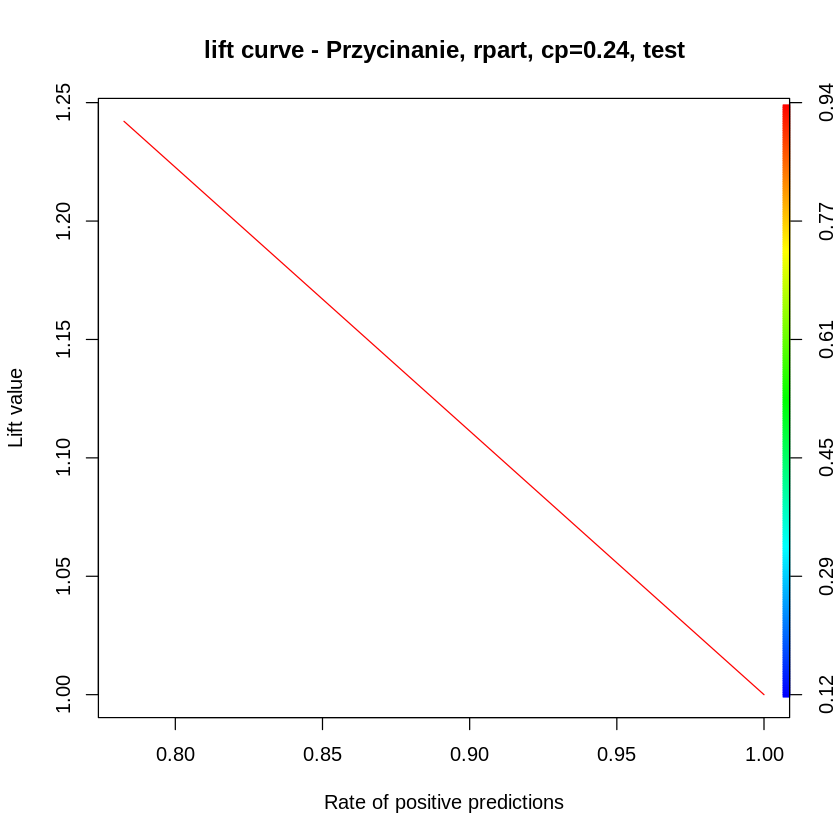

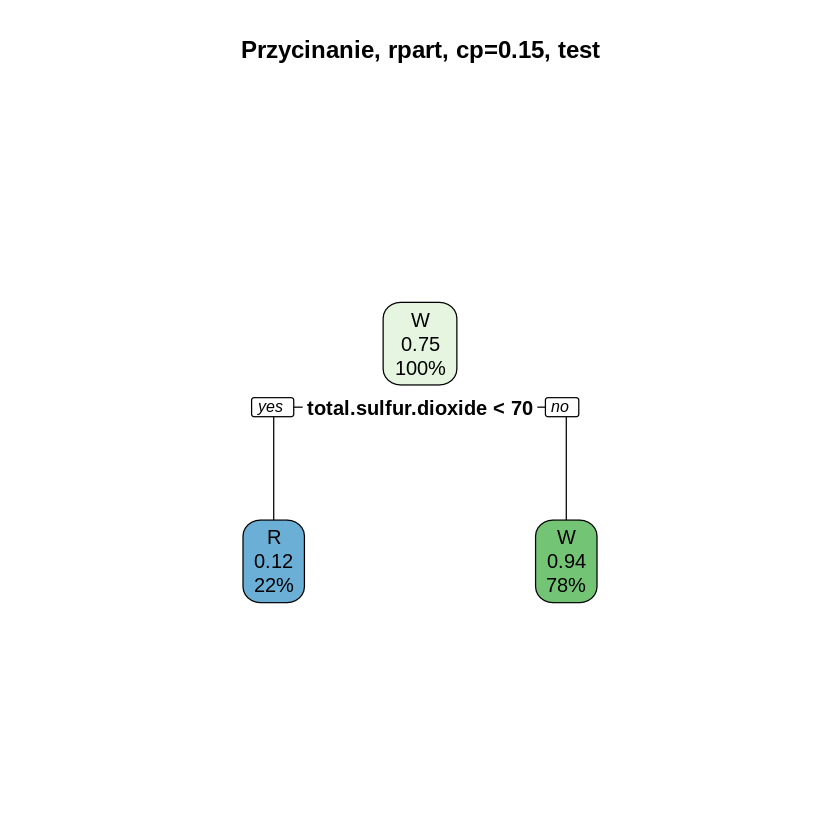

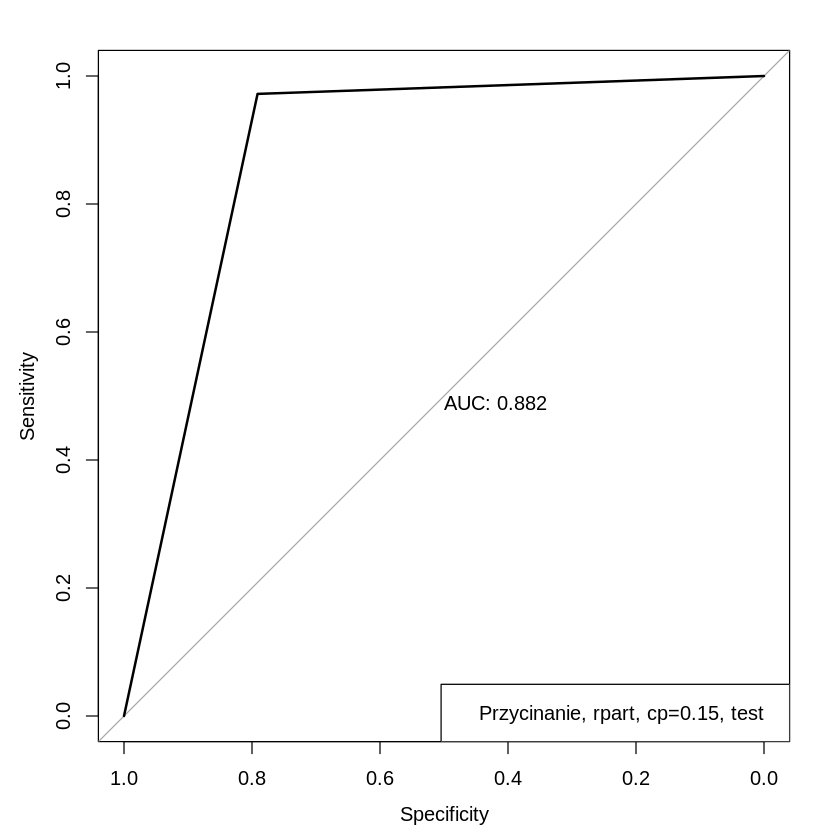

[1] "Przycinanie, rpart, cp=0.11, test"
          Reference
Prediction    R    W
         R  383  101
         W   41 1425
      Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
      9.27e-01       7.96e-01       9.15e-01       9.38e-01       7.83e-01 
AccuracyPValue  McnemarPValue 
      9.94e-68       7.38e-07 
         Sensitivity          Specificity       Pos Pred Value 
               0.903                0.934                0.791 
      Neg Pred Value            Precision               Recall 
               0.972                0.791                0.903 
                  F1           Prevalence       Detection Rate 
               0.844                0.217                0.196 
Detection Prevalence    Balanced Accuracy 
               0.248                0.919 


Setting levels: control = R, case = W

Setting direction: controls > cases



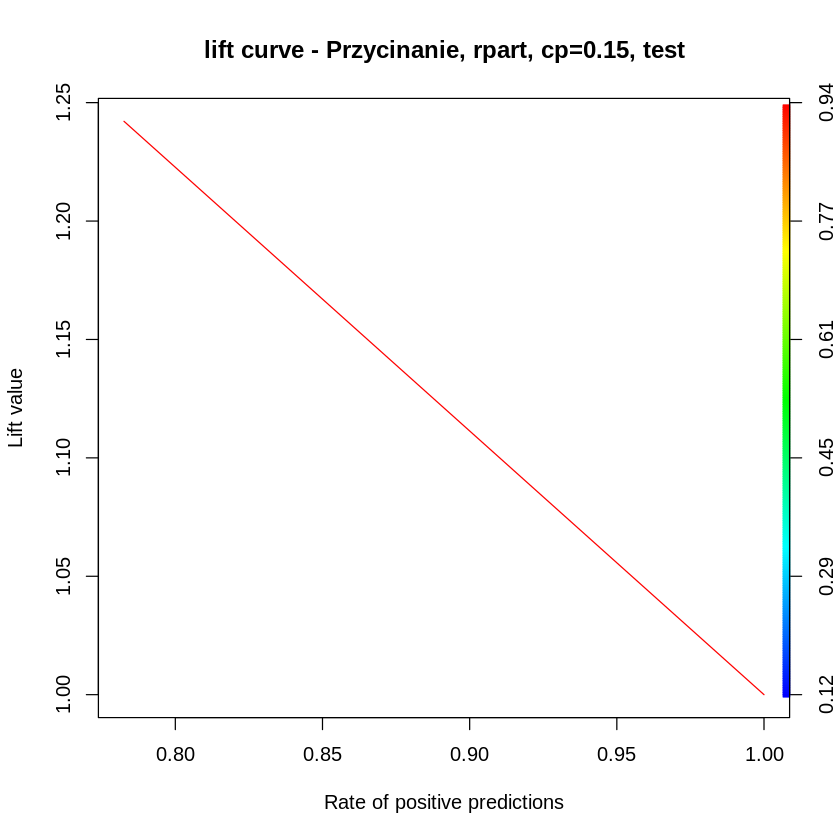

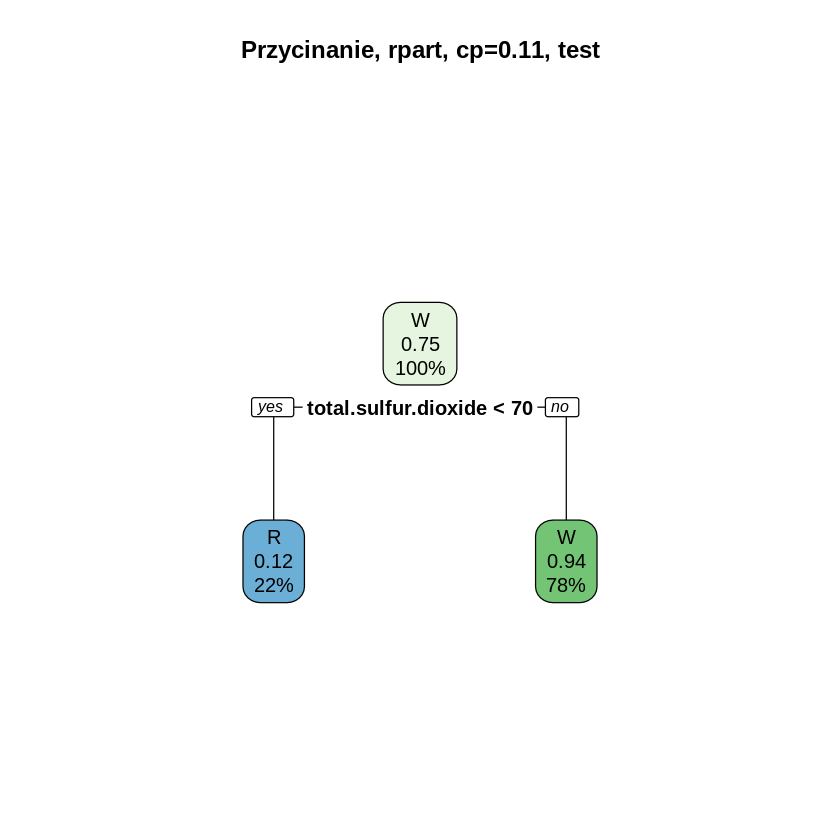

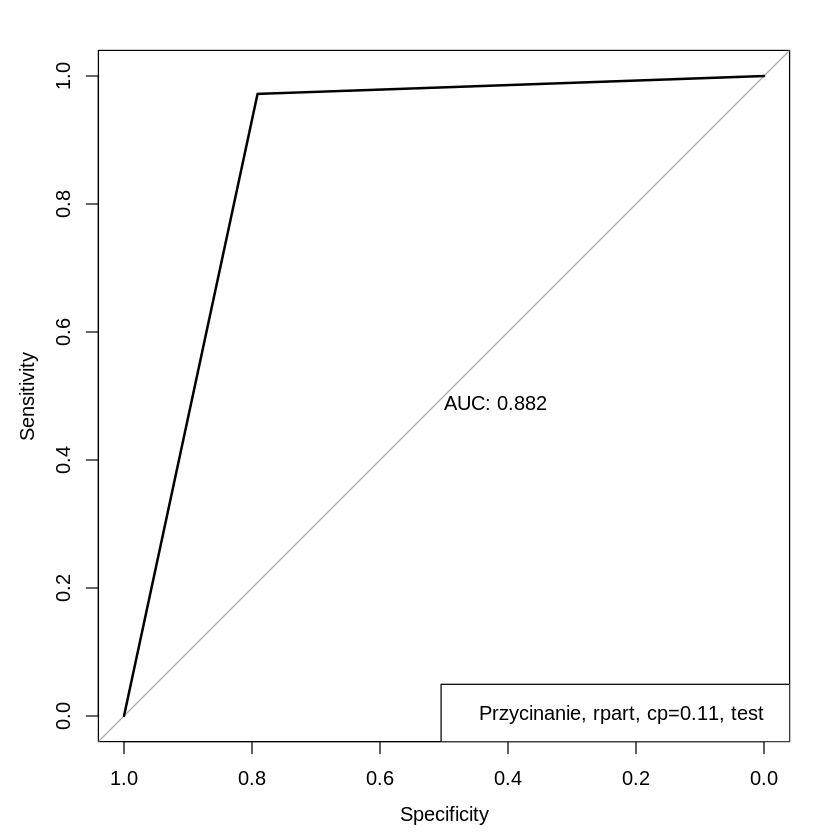

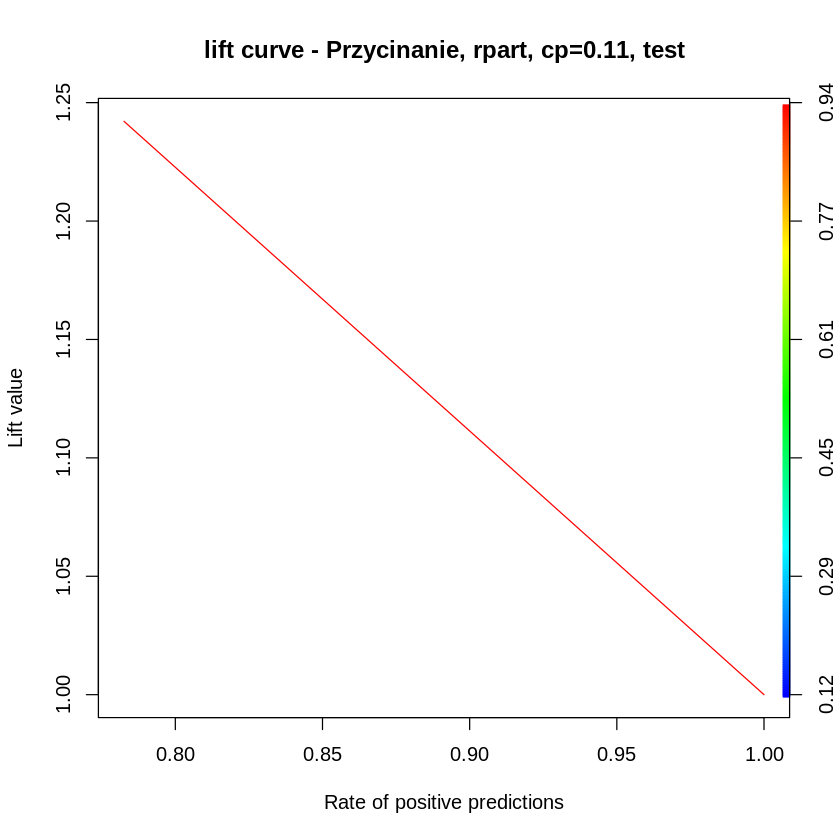

In [26]:


# Przeglad drzew przycietych dla roznych wartosci parametru zlozonosci. Zebranie przy okazji maciezy pomylek dla porownania.

for (c in rpTree$cptable[,"xerror"])
{
  text = sprintf("%s, %s, cp=%.2f, %s","Przycinanie","rpart", c, "test")
  print (text)
  
  #pRpTree<- prune(rpTree, cp = rpTree.cp)
  pRpTree<- prune(rpTree, cp = c)
  
  rpart.plot(pRpTree, main=text)
  
  cm = model_stats(pRpTree, test)
  results = store_cm(results, cm, c(try_num=next_try(),desc=text, tree_type = 'rpTree-prunned', type='test') )
  
  # Dla drzewa z jednym wezlem jest tylko jedna klasa i nie narysuja sie wykresy ROC i lift
  if (c < 1) 
  {
    draw_roc_lift(pRpTree, test, text)
  }
  
  #cm = model_stats(pRpTree, train)
  #results = store_cm(results, cm, c(try_num=next_try(),desc=text, tree_type = 'rpTree-prunned', type='train') )

}




Naive Bayes Classifier for Discrete Predictors

Call:
naiveBayes.default(x = X, y = Y, laplace = laplace)

A-priori probabilities:
Y
    R     W 
0.245 0.755 

Conditional probabilities:
   fixed.acidity
Y   [,1]  [,2]
  R 8.35 1.715
  W 6.87 0.849

   volatile.acidity
Y   [,1]  [,2]
  R 0.53 0.180
  W 0.28 0.103

   citric.acid
Y    [,1]  [,2]
  R 0.267 0.196
  W 0.334 0.121

   residual.sugar
Y   [,1] [,2]
  R 2.55 1.46
  W 6.33 5.09

   chlorides
Y     [,1]   [,2]
  R 0.0877 0.0478
  W 0.0460 0.0227

   free.sulfur.dioxide
Y   [,1] [,2]
  R 15.8 10.4
  W 34.8 16.6

   total.sulfur.dioxide
Y    [,1] [,2]
  R  45.8 32.5
  W 137.9 42.4

   density
Y    [,1]    [,2]
  R 0.997 0.00189
  W 0.994 0.00302

   pH
Y   [,1]  [,2]
  R 3.31 0.156
  W 3.19 0.153

   sulphates
Y    [,1]  [,2]
  R 0.658 0.172
  W 0.489 0.114

   alcohol
Y   [,1] [,2]
  R 10.4 1.06
  W 10.5 1.23

   quality
Y   [,1]  [,2]
  R 5.64 0.817
  W 5.86 0.894

          Reference
Prediction    R    W
         R  461   23
 

Setting levels: control = R, case = W

Setting direction: controls > cases



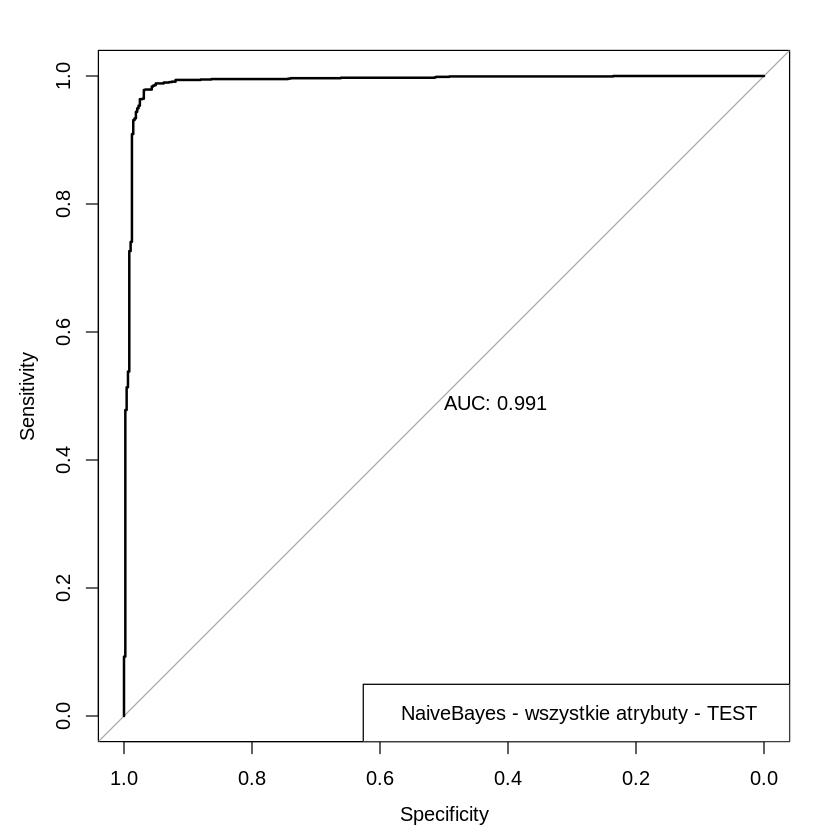

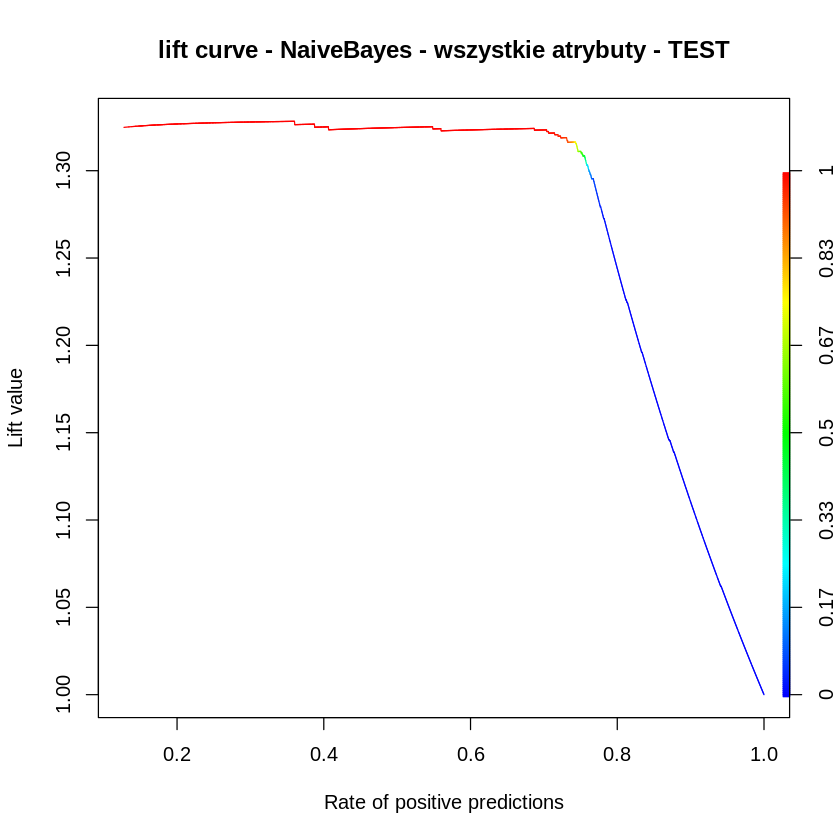

In [27]:

#View(results)


# 
# III. Dla porowniania - klasyfikator NaiveBayes
#

#
# 1. Proba dla wszystkich zmiennych obajniajacych
# 

wines = wines_orginal

train_test = split_train_test(wines, 0.7)
train = train_test$train
test = train_test$test

nbClasif <- naiveBayes(class ~ ., data=train)
print(nbClasif)

#cm = confusionMatrix(nbClasifTable, mode="prec_recall")

# Pokaze tablice pomylek i statystyki
cm = model_stats(nbClasif, test)
draw_roc_lift(nbClasif, test, "NaiveBayes - wszystkie atrybuty - TEST", pred_result_type='raw')

results = store_cm(results, cm, c(try_num=next_try(),desc='Wszystkie atrybuty', tree_type = 'NaiveBayes', type='test') )




Naive Bayes Classifier for Discrete Predictors

Call:
naiveBayes.default(x = X, y = Y, laplace = laplace)

A-priori probabilities:
Y
    R     W 
0.245 0.755 

Conditional probabilities:
   chlorides
Y     [,1]   [,2]
  R 0.0877 0.0478
  W 0.0460 0.0227

   total.sulfur.dioxide
Y    [,1] [,2]
  R  45.8 32.5
  W 137.9 42.4

          Reference
Prediction    R    W
         R  402   82
         W   46 1420
      Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
      9.34e-01       8.20e-01       9.22e-01       9.45e-01       7.70e-01 
AccuracyPValue  McnemarPValue 
      3.11e-85       1.98e-03 
         Sensitivity          Specificity       Pos Pred Value 
               0.897                0.945                0.831 
      Neg Pred Value            Precision               Recall 
               0.969                0.831                0.897 
                  F1           Prevalence       Detection Rate 
               0.863                0.230                

Setting levels: control = R, case = W

Setting direction: controls > cases



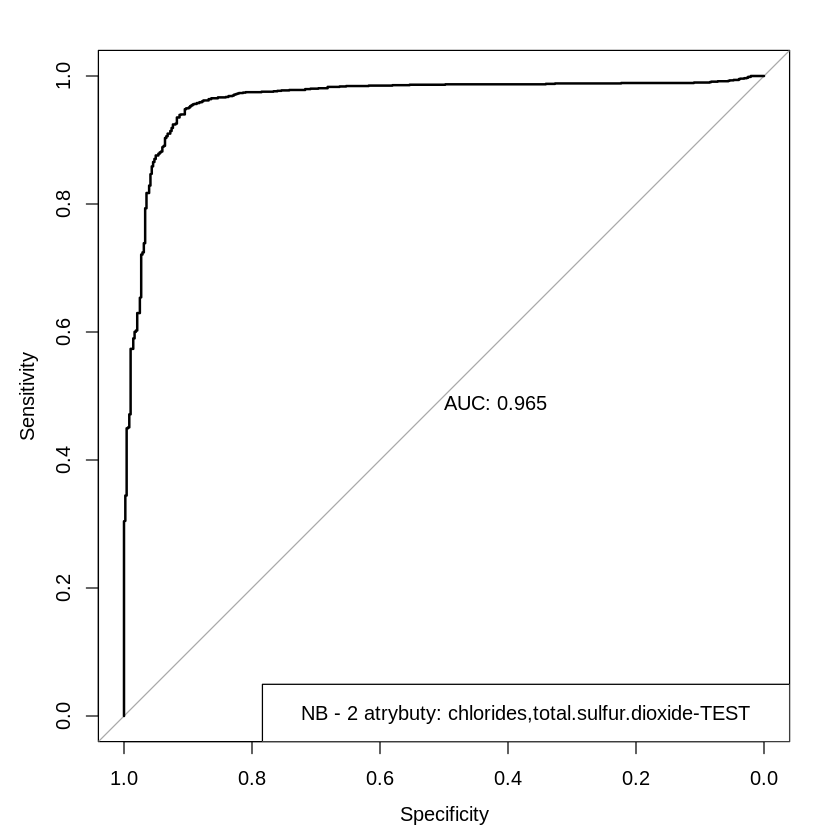

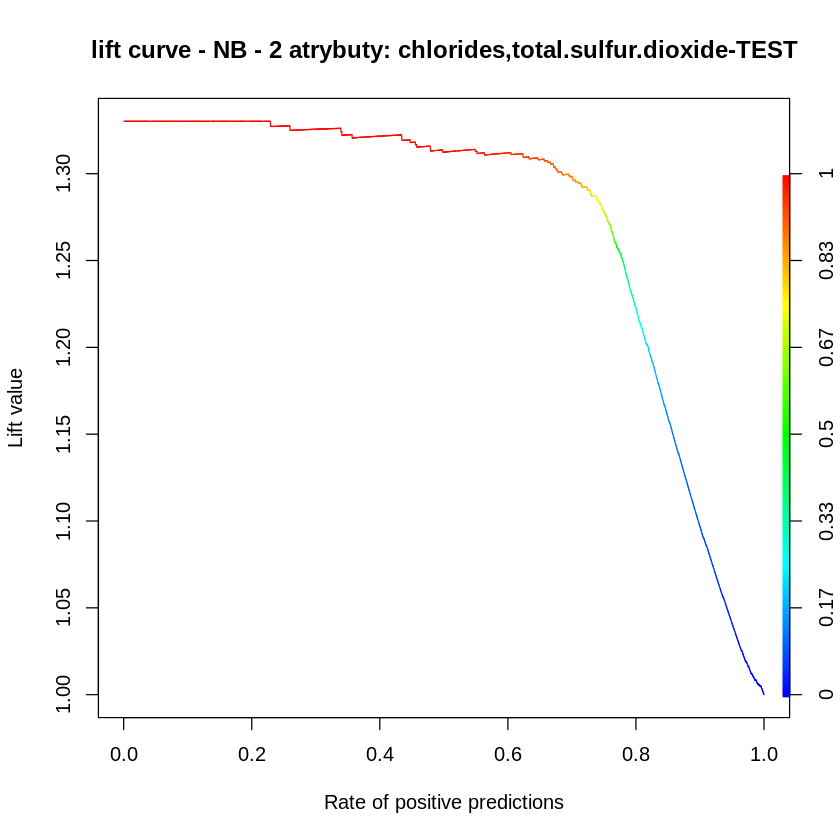

In [30]:

#
# 2. Proba dla 2 attrybutow, ktore poprzednio dawaly najlepsze wyniki
# 

nbClasif <- naiveBayes(class ~ chlorides + total.sulfur.dioxide, data=train)
print(nbClasif)

# Pokaze tablice pomylek i statystyki
cm = model_stats(nbClasif, test)
draw_roc_lift(nbClasif, test, "NB - 2 atrybuty: chlorides,total.sulfur.dioxide-TEST", pred_result_type='raw')

results = store_cm(results, cm, c(try_num=next_try(),desc='2 atrybuty: chlorides, total.sulfur.dioxide', tree_type = 'NaiveBayes', type='test') )

#View(results)

# WNIOSKI: Dla wszystkich atrybutow, sprawnosc klasyfikatora jest zblizona do C5.0 i drzewa rpart. Widac to 
#          Na wykresach ROC i podniesienia. Natomiast dla 2 atrybotow, ktore dla drzew dawaly stosunkowo dobra sprawnosc,
#          NB ma wyrazny spadek skutecznosci dla czesci probek testowych, widac do na ostatnim wykresie podniesienia.


# KONIEC #



